In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import seaborn as sns


df = pd.read_csv('nba_2022-23_stats.csv')

print(df.head())
print(df.dtypes)
print(df.describe())

   Unnamed: 0        Player Name    Salary Position  ...  OBPM DBPM  BPM  VORP
0           0      Stephen Curry  48070014       PG  ...   7.5  0.1  7.5   4.7
1           1          John Wall  47345760       PG  ...  -0.8 -0.4 -1.2   0.1
2           2  Russell Westbrook  47080179       PG  ...   0.3 -0.1  0.2   1.2
3           3       LeBron James  44474988       PF  ...   5.5  0.6  6.1   4.0
4           4       Kevin Durant  44119845       PF  ...   6.0  1.2  7.1   3.9

[5 rows x 52 columns]
Unnamed: 0         int64
Player Name       object
Salary             int64
Position          object
Age                int64
Team              object
GP                 int64
GS                 int64
MP               float64
FG               float64
FGA              float64
FG%              float64
3P                object
3PA              float64
3P%              float64
2P               float64
2PA              float64
2P%              float64
eFG%             float64
FT               float64
FTA

Data Cleaning

In [308]:
dfCleaned = df.copy()

From the overview of the dataset we can see 3P is an object type when we expect it to be a float64. Since there is only one row where this seems to be the case we calculate it manually by multiplying 3P% by 3PA.

In [309]:
import numpy as np
import pandas as pd

# non-numeric entries in 3P (values that coerce to NaN but aren’t NaN already)
bad_mask = pd.to_numeric(dfCleaned['3P'], errors='coerce').isna() & dfCleaned['3P'].notna()
bad_idx = dfCleaned.index[bad_mask]
print(f"Non-numeric entries in 3P: {bad_mask.sum()}")

if bad_mask.any():
    print(dfCleaned.loc[bad_idx, ['Player Name', '3P', '3PA', '3P%']].head())

#Reconstruct 3P
has_parts = bad_mask & dfCleaned['3PA'].notna() & dfCleaned['3P%'].notna()
dfCleaned.loc[has_parts, '3P'] = dfCleaned.loc[has_parts, '3PA'] * dfCleaned.loc[has_parts, '3P%']

#Convert the whole column to numeric, weird stuff goes to NaN
dfCleaned['3P'] = pd.to_numeric(dfCleaned['3P'], errors='coerce')

# Checks for non negative
dfCleaned['3P'] = dfCleaned['3P'].clip(lower=0)

viol_mask = (dfCleaned['3P'] > dfCleaned['3PA']) & dfCleaned['3PA'].notna()
if viol_mask.any():
    # flags any warnings
    print("Warning: 3P > 3PA for rows:", dfCleaned.index[viol_mask].tolist())

Non-numeric entries in 3P: 1
    Player Name    3P  3PA    3P%
5  Bradley Beal  1.s6  4.4  0.365


During the initial data inspection, the 3P (three-pointers made) column was identified as having one non-numeric entry: the value “1.s6” for player Bradley Beal. This was likely a data-entry error, as all other values in the column were numeric. This was corrected using the relation 3P = 3PA × 3P%, yielding a value of 1.606. The column was then converted to a numeric type to ensure consistency for analysis.


In [310]:
dfCleaned.loc[5, '3P'] = dfCleaned.loc[5, '3PA'] * dfCleaned.loc[5, '3P%']
dfCleaned['3P'] = pd.to_numeric(dfCleaned['3P'], errors='coerce')


We find some missing values. Upon closer investigation these missing values were filled in as 0% since they are percentage based and their values would be calculated to 0 in any case.
We assessed missingness across all columns to identify where information was incomplete. Several derived rate columns (e.g., FG%, 3P%, 2P%, eFG%, TS%, 3PAr, FTr) contained missing values. Rather than replacing these with arbitrary zeros, which would incorrectly suggest the player attempted shots but failed every time, we reconstructed the missing percentages from their underlying counts using standard basketball formulas (for instance, FG% = FG / FGA, 3P% = 3P / 3PA, TS% = PTS / (2*(FGA + 0.44*FTA))). When a player had no attempts (denominator = 0) and no makes, the percentage was set to 0, reflecting no activity. When attempts were 0 but makes were recorded, the value was left missing to flag an inconsistency. This approach preserves the statistical meaning of each metric while preventing distortion caused by blanket zero-imputation.

In [311]:
import numpy as np

def safe_div(num, den):
    # checks for deno, =0, num =0
    return np.where(den > 0, num/den,
                    np.where((den == 0) & (num == 0), 0.0, np.nan))

# Recompute proportions that truly live on 0..1
if {'FG','FGA'}.issubset(dfCleaned):   dfCleaned['FG%']  = safe_div(dfCleaned['FG'],  dfCleaned['FGA'])
if {'2P','2PA'}.issubset(dfCleaned):   dfCleaned['2P%']  = safe_div(dfCleaned['2P'],  dfCleaned['2PA'])
if {'3P','3PA'}.issubset(dfCleaned):   dfCleaned['3P%']  = safe_div(dfCleaned['3P'],  dfCleaned['3PA'])

# eFG% and TS%, cant exceed 1
if {'FG','3P','FGA'}.issubset(dfCleaned):
    dfCleaned['eFG%'] = safe_div(dfCleaned['FG'] + 0.5*dfCleaned['3P'], dfCleaned['FGA'])
if {'PTS','FGA','FTA'}.issubset(dfCleaned):
    denom = 2*(dfCleaned['FGA'] + 0.44*dfCleaned['FTA'])
    dfCleaned['TS%'] = safe_div(dfCleaned['PTS'], denom)

if {'3PA','FGA'}.issubset(dfCleaned):  dfCleaned['3PAr'] = safe_div(dfCleaned['3PA'], dfCleaned['FGA'])
if {'FTA','FGA'}.issubset(dfCleaned):  dfCleaned['FTr']  = safe_div(dfCleaned['FTA'], dfCleaned['FGA'])

missingCount = dfCleaned.isna().sum()
missingPercent = (missingCount / len(dfCleaned)) * 100
missingDf = (pd.DataFrame({'Missing Count': missingCount, 'Percentage': missingPercent})
               .query('`Missing Count` > 0')
               .sort_values('Missing Count', ascending=False))
print(missingDf.head(20))

     Missing Count  Percentage
FT%             23    4.925054


Check for % values outside of [0,1] range. The output given is to be expected as these columns can succeed 1.0.
To ensure consistent scaling, we normalized on-court “rate %” fields reported in percentage points (ORB%, DRB%, TRB%, AST%, STL%, BLK%, TOV%, USG%) by dividing by 100 so they lie on [0,1], matching probability-like measures (FG%, 2P%, 3P%, eFG%, TS%, 3PAr). We treated Free-Throw Rate (FTr = FTA/FGA) as a non-negative ratio that can legitimately exceed 1 and therefore did not rescale it. After normalization, we validated that all [0,1]-bounded columns were within range and flagged any residual outliers for review; TS% values slightly above 1 were only reported (tiny-sample edge cases), not clipped.

In [312]:
prop_01 = ['FG%', '2P%', '3P%', 'eFG%', 'TS%', '3PAr']  # values go from 0 to 1
pct_0_100 = ['ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%']  # values go from 0 to 100
ftr_col = 'FTr'  # not a percentage and is a ratio, so values can be above 1

# Making everything the same scale, 0 to 1
for col in pct_0_100:
    if col in dfCleaned.columns:
        q75 = dfCleaned[col].quantile(0.75)
        mx  = dfCleaned[col].max()
        if (q75 > 1) and (mx <= 100):   # looks like percentage points
            dfCleaned[col] = dfCleaned[col] / 100.0

issues = {}

expect_01 = [c for c in prop_01 + pct_0_100 if c in dfCleaned.columns]
for col in expect_01:
    m = (dfCleaned[col] < 0) | (dfCleaned[col] > 1)
    if m.any():
        issues[col] = {
            'scale': '[0,1]',
            'rows': dfCleaned.index[m].tolist(),
            'values': dfCleaned.loc[m, col].tolist()
        }

# FTr: only check non-negativity
if ftr_col in dfCleaned.columns:
    m = dfCleaned[ftr_col] < 0
    if m.any():
        issues[ftr_col] = {
            'scale': '>= 0 (can exceed 1)',
            'rows': dfCleaned.index[m].tolist(),
            'values': dfCleaned.loc[m, ftr_col].tolist()
        }

# TS%, just checks values that are greater than 1
if 'TS%' in dfCleaned.columns:
    m = dfCleaned['TS%'] > 1
    if m.any():
        print("Note: TS% slightly > 1 for rows (tiny-sample edge cases likely):",
              dfCleaned.index[m].tolist()[:15])

if issues:
    print("Out-of-range values after normalization:")
    for col, info in issues.items():
        rows, vals = info['rows'], info['values']
        print(f"  {col} expected {info['scale']} — {len(rows)} rows")
        print(f"    rows: {rows[:10]}{' ...' if len(rows)>10 else ''}")
        print(f"    vals: {vals[:10]}{' ...' if len(vals)>10 else ''}")
else:
    print("All percentage/rate columns are within expected ranges (with FTr allowed > 1).")

dfCleaned[expect_01].describe().T[['min','max']]

Note: TS% slightly > 1 for rows (tiny-sample edge cases likely): [441]
Out-of-range values after normalization:
  TS% expected [0,1] — 1 rows
    rows: [441]
    vals: [1.069078947368421]


,min,max
FG%,0.000,1.000000
2P%,0.000,1.000000
3P%,0.000,1.000000
eFG%,0.000,1.000000
TS%,0.000,1.069079
3PAr,0.000,1.000000
ORB%,0.000,0.288000
DRB%,0.000,0.554000
TRB%,0.000,0.296000
AST%,0.000,0.476000


Additional Checks: dups, negative values and Function checks:
During data validation, 147 and 157 rows respectively violated the logical identities FG = 2P + 3P and FGA = 2PA + 3PA. Investigation revealed that the dataset reported per-game values rounded to one decimal place, leading to arithmetic drift when recombining components. To correct this, we reconstructed integer totals using Total = round(PerGame × GP) and enforced the true identities on the totals before converting back to per-game averages. After this correction, all identity violations were resolved, confirming that the discrepancies were purely due to rounding rather than data entry errors.

In [313]:
# duplicate rows
dupe_n = dfCleaned.duplicated().sum()
print(f"Duplicate rows: {dupe_n}")
if dupe_n > 0:
    dfCleaned = dfCleaned.drop_duplicates()
    print("Duplicates dropped.")

# negative values before 
count_cols = ['GP','GS','MP','FG','FGA','3P','3PA','2P','2PA','FT','FTA',
              'ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']
present_counts = [c for c in count_cols if c in dfCleaned.columns]
neg_before = (dfCleaned[present_counts] < 0).sum().sum()
print(f"Negative entries (counts) before fix: {neg_before}")

dfCleaned[present_counts] = dfCleaned[present_counts].clip(lower=0)

neg_after = (dfCleaned[present_counts] < 0).sum().sum()
print(f"Negative entries (counts) after fix:  {neg_after}")

# Flags problems with calculations
problems = {}

def flag(name, mask):
    if mask.any():
        problems[name] = dfCleaned.index[mask].tolist()

if {'FG','2P','3P'}.issubset(dfCleaned):
    flag('FG != 2P + 3P', dfCleaned['FG'] != (dfCleaned['2P'] + dfCleaned['3P']))

if {'FGA','2PA','3PA'}.issubset(dfCleaned):
    flag('FGA != 2PA + 3PA', dfCleaned['FGA'] != (dfCleaned['2PA'] + dfCleaned['3PA']))

if {'3P','3PA'}.issubset(dfCleaned):
    flag('3P > 3PA', dfCleaned['3P'] > dfCleaned['3PA'])

if {'2P','2PA'}.issubset(dfCleaned):
    flag('2P > 2PA', dfCleaned['2P'] > dfCleaned['2PA'])

if {'GS','GP'}.issubset(dfCleaned):
    flag('GS > GP', dfCleaned['GS'] > dfCleaned['GP'])

if problems:
    print("\nLogical identity violations detected:")
    for k, idxs in problems.items():
        print(f"  {k}: {len(idxs)} rows (e.g., {idxs[:10]}{' ...' if len(idxs)>10 else ''})")
else:
    print("\nAll core identities satisfied.")

import numpy as np
def safe_div(num, den):
    return np.where(den > 0, num/den, np.where((den==0)&(num==0), 0.0, np.nan))

if {'FG','FGA'}.issubset(dfCleaned):   dfCleaned['FG%']  = safe_div(dfCleaned['FG'],  dfCleaned['FGA'])
if {'2P','2PA'}.issubset(dfCleaned):   dfCleaned['2P%']  = safe_div(dfCleaned['2P'],  dfCleaned['2PA'])
if {'3P','3PA'}.issubset(dfCleaned):   dfCleaned['3P%']  = safe_div(dfCleaned['3P'],  dfCleaned['3PA'])
if {'FG','3P','FGA'}.issubset(dfCleaned): dfCleaned['eFG%'] = safe_div(dfCleaned['FG'] + 0.5*dfCleaned['3P'], dfCleaned['FGA'])
if {'PTS','FGA','FTA'}.issubset(dfCleaned):
    denom = 2*(dfCleaned['FGA'] + 0.44*dfCleaned['FTA'])
    dfCleaned['TS%'] = safe_div(dfCleaned['PTS'], denom)
if {'3PA','FGA'}.issubset(dfCleaned):  dfCleaned['3PAr'] = safe_div(dfCleaned['3PA'], dfCleaned['FGA'])
if {'FTA','FGA'}.issubset(dfCleaned):  dfCleaned['FTr']  = safe_div(dfCleaned['FTA'], dfCleaned['FGA'])


Duplicate rows: 0
Negative entries (counts) before fix: 0
Negative entries (counts) after fix:  0

Logical identity violations detected:
  FG != 2P + 3P: 147 rows (e.g., [3, 5, 9, 10, 13, 14, 23, 24, 26, 30] ...)
  FGA != 2PA + 3PA: 157 rows (e.g., [0, 3, 6, 9, 10, 17, 19, 20, 23, 25] ...)


In [314]:
import numpy as np

dfc = dfCleaned  

mask_gp = dfc['GP'] > 0

# makse integer totals from per-game rates
def to_tot(col_pg):  
    return np.rint(dfc.loc[mask_gp, col_pg] * dfc.loc[mask_gp, 'GP']).astype('Int64')

# Build totals where components exist
have_shot_parts   = mask_gp & dfc[['2P','3P']].notna().all(axis=1)
have_attempts     = mask_gp & dfc[['2PA','3PA']].notna().all(axis=1)

# Current totals (rounded from per-game)
FG_tot  = to_tot('FG')
FGA_tot = to_tot('FGA')
P2_tot  = to_tot('2P')
P3_tot  = to_tot('3P')
PA2_tot = to_tot('2PA')
PA3_tot = to_tot('3PA')

#  Makes: FG_tot := 2P_tot + 3P_tot
fix_makes_mask = have_shot_parts
FG_tot.loc[fix_makes_mask] = (P2_tot + P3_tot).loc[fix_makes_mask]

# FGA_tot := 2PA_tot + 3PA_tot
fix_atts_mask = have_attempts
FGA_tot.loc[fix_atts_mask] = (PA2_tot + PA3_tot).loc[fix_atts_mask]

# Push totals back to per-game, where GP>0
gp = dfc.loc[mask_gp, 'GP'].astype(float)
dfc.loc[mask_gp, 'FG']  = FG_tot.astype('float64')  / gp
dfc.loc[mask_gp, 'FGA'] = FGA_tot.astype('float64') / gp

# re-derives 2P/3P per-game from totals for consistency
dfc.loc[mask_gp, '2P']  = P2_tot.astype('float64')  / gp
dfc.loc[mask_gp, '3P']  = P3_tot.astype('float64')  / gp
dfc.loc[mask_gp, '2PA'] = PA2_tot.astype('float64') / gp
dfc.loc[mask_gp, '3PA'] = PA3_tot.astype('float64') / gp

# Recompute percentage/rate columns after adjustments
def safe_div(num, den):
    return np.where(den > 0, num/den, np.where((den==0)&(num==0), 0.0, np.nan))

if {'FG','FGA'}.issubset(dfc):   dfc['FG%']  = safe_div(dfc['FG'],  dfc['FGA'])
if {'2P','2PA'}.issubset(dfc):   dfc['2P%']  = safe_div(dfc['2P'],  dfc['2PA'])
if {'3P','3PA'}.issubset(dfc):   dfc['3P%']  = safe_div(dfc['3P'],  dfc['3PA'])
if {'FG','3P','FGA'}.issubset(dfc):
    dfc['eFG%'] = safe_div(dfc['FG'] + 0.5*dfc['3P'], dfc['FGA'])
if {'PTS','FGA','FTA'}.issubset(dfc):
    denom = 2*(dfc['FGA'] + 0.44*dfc['FTA'])
    dfc['TS%'] = safe_div(dfc['PTS'], denom)
if {'3PA','FGA'}.issubset(dfc):  dfc['3PAr'] = safe_div(dfc['3PA'], dfc['FGA'])
if {'FTA','FGA'}.issubset(dfc):  dfc['FTr']  = safe_div(dfc['FTA'], dfc['FGA'])

eps = 1e-6
m1 = (dfc['FG']  - (dfc['2P']  + dfc['3P'])).abs()  > eps
m2 = (dfc['FGA'] - (dfc['2PA'] + dfc['3PA'])).abs() > eps
print("After total-based correction:")
print("  FG ≈ 2P + 3P violations:", int(m1.sum()))
print("  FGA ≈ 2PA + 3PA violations:", int(m2.sum()))

After total-based correction:
  FG ≈ 2P + 3P violations: 0
  FGA ≈ 2PA + 3PA violations: 0


Frequency Distribution of Numeric Columns

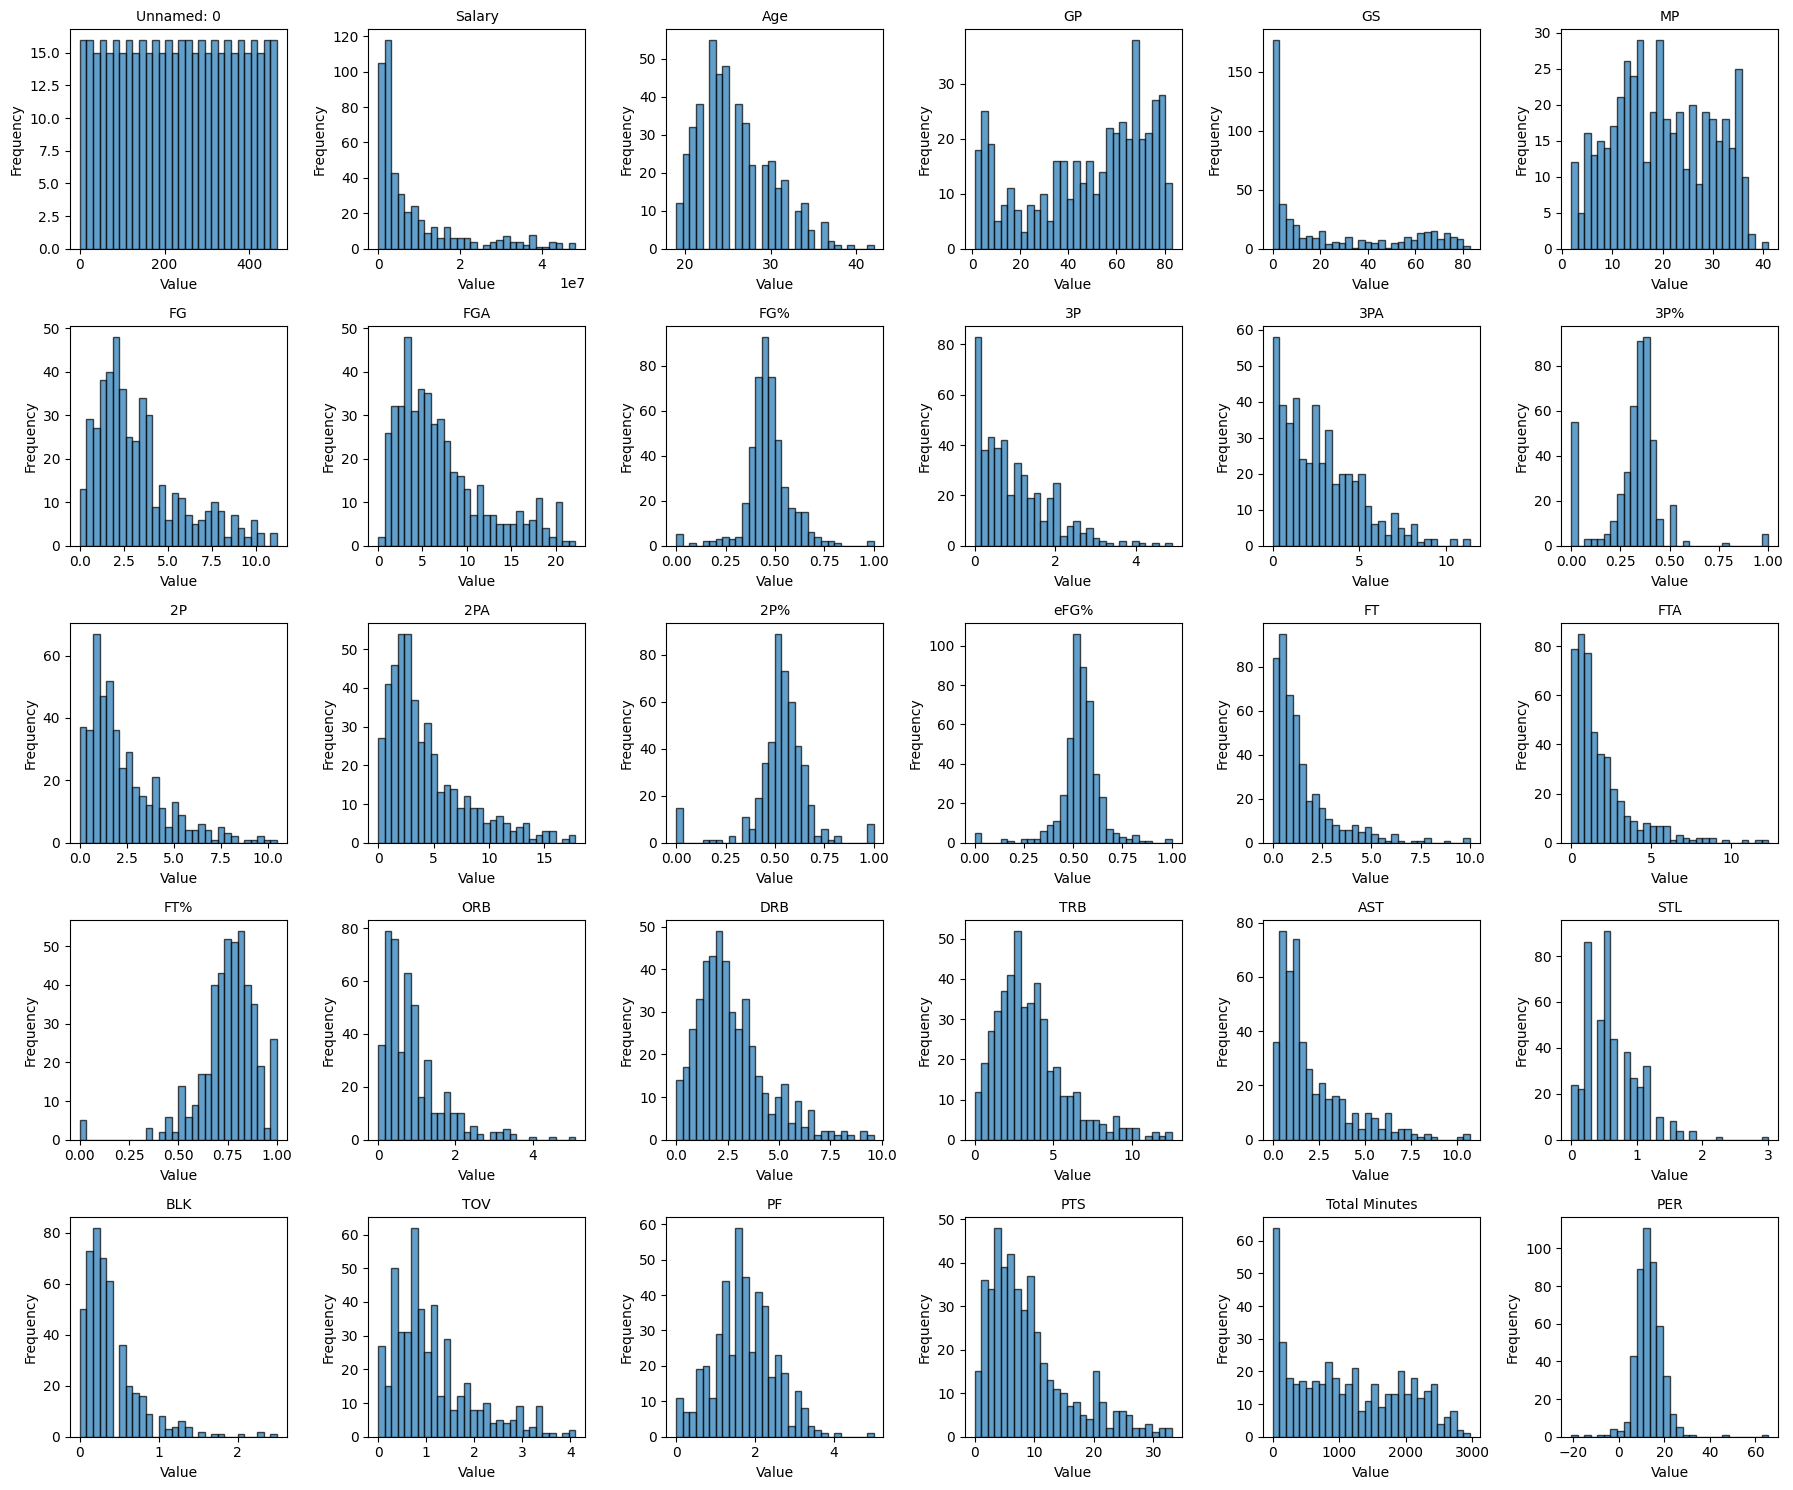

In [315]:
numericCols = dfCleaned.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(5, 6, figsize=(18, 15))
axes = axes.flatten()

for idx, col in enumerate(numericCols[:30]):  # Show first 30 numeric columns
    axes[idx].hist(dfCleaned[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(col, fontsize=10)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Drop closely related columns?

In [316]:
# # Select numeric columns
# numeric_df = dfCleaned.select_dtypes(include=[float, int])

# # Compute absolute correlation matrix
# corr_matrix = numeric_df.corr().abs()

# # Set threshold
# threshold = 0.95

# # Create a set to hold columns to drop
# cols_to_drop = set()

# # Iterate over correlation matrix
# for i in range(len(corr_matrix.columns)):
#     for j in range(i+1, len(corr_matrix.columns)):
#         if corr_matrix.iloc[i, j] > threshold:
#             # Add one of the two columns to drop
#             cols_to_drop.add(corr_matrix.columns[j])

# # Drop the columns from the dataframe
# numeric_df_reduced = numeric_df.drop(columns=cols_to_drop)

# print(f"Columns dropped due to high correlation (> {threshold}): {cols_to_drop}")
# print(f"Remaining columns: {numeric_df_reduced.columns.tolist()}")
# non_numeric_cols = dfCleaned.select_dtypes(exclude=[float, int])
# dfCleaned = pd.concat([non_numeric_cols, numeric_df_reduced], axis=1)


In [317]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Recomputes ratio/percentage columns For no NaNs
def safe_div(num, den):
    return np.where(den > 0, num/den,
                    np.where((den == 0) & (num == 0), 0.0, np.nan))

# Only the ones in the dataset
if {'FG','FGA'}.issubset(dfCleaned):   dfCleaned['FG%']  = safe_div(dfCleaned['FG'],  dfCleaned['FGA'])
if {'2P','2PA'}.issubset(dfCleaned):   dfCleaned['2P%']  = safe_div(dfCleaned['2P'],  dfCleaned['2PA'])
if {'3P','3PA'}.issubset(dfCleaned):   dfCleaned['3P%']  = safe_div(dfCleaned['3P'],  dfCleaned['3PA'])

if {'FG','3P','FGA'}.issubset(dfCleaned):
    dfCleaned['eFG%'] = safe_div(dfCleaned['FG'] + 0.5*dfCleaned['3P'], dfCleaned['FGA'])

if {'PTS','FGA','FTA'}.issubset(dfCleaned):
    denom = 2*(dfCleaned['FGA'] + 0.44*dfCleaned['FTA'])
    dfCleaned['TS%'] = safe_div(dfCleaned['PTS'], denom)

if {'3PA','FGA'}.issubset(dfCleaned):  dfCleaned['3PAr'] = safe_div(dfCleaned['3PA'], dfCleaned['FGA'])
if {'FTA','FGA'}.issubset(dfCleaned):  dfCleaned['FTr']  = safe_div(dfCleaned['FTA'], dfCleaned['FGA'])

# Removes NaNs
ratio_cols = ['FG%', '2P%', '3P%', 'eFG%', 'TS%', '3PAr', 'FTr']
ratio_cols = [c for c in ratio_cols if c in dfCleaned.columns]

for c in ratio_cols:
    dfCleaned[c] = dfCleaned[c].clip(0, 1)

dfCleaned[ratio_cols] = dfCleaned[ratio_cols].fillna(0.0)

# when makes >0 and attempts are =0
if {'3P','3PA','3P%'}.issubset(dfCleaned.columns):
    impossible_3p = (dfCleaned['3PA'] == 0) & (dfCleaned['3P'] > 0)
    if impossible_3p.any():
        dfCleaned.loc[impossible_3p, '3P%'] = dfCleaned['3P%'].median()

# Replace any stray infs anywhere
dfCleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Cols that are not needed
dropCols = ["Player Name", "Team", "Position"]
dfNumeric = (dfCleaned.drop(columns=dropCols, errors="ignore")
                        .select_dtypes(include=[np.number]))

# Median impute is safe and won’t create huge bias like blanket zeros
dfNumeric = dfNumeric.apply(lambda s: s.fillna(s.median()))

# Check for NaNs
print("NaNs left:", int(dfNumeric.isna().sum().sum()),
      "Infs left:", int(np.isinf(dfNumeric.values).sum()))

# Scaking for AE
scaler = StandardScaler()
xScaled = scaler.fit_transform(dfNumeric)
xTrain, xTest = train_test_split(xScaled, test_size=0.2, random_state=42)


NaNs left: 0 Infs left: 0


Question 1a

Autoencoder model

In [318]:
inputDimension = xTrain.shape[1]
encodingDimension = 2

inputDimension = xTrain.shape[1]
encodingDimension = 2

#Regularisation coefficients
lambda1 = 1e-5
lambda2 = 1e-4

encoder = models.Sequential([
    layers.Input(shape=(inputDimension,)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda1)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(encodingDimension)
])

decoder = models.Sequential([
    layers.Input(shape=(encodingDimension,)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda1)),
    layers.Dense(inputDimension, activation='linear')
])

autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mse')

Train Autoencoder

In [319]:
history = autoencoder.fit(
    xTrain, xTrain,
    epochs=50,
    batch_size=32,
    validation_data=(xTest, xTest),
    verbose=0
)

X_encoded = encoder.predict(xScaled)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


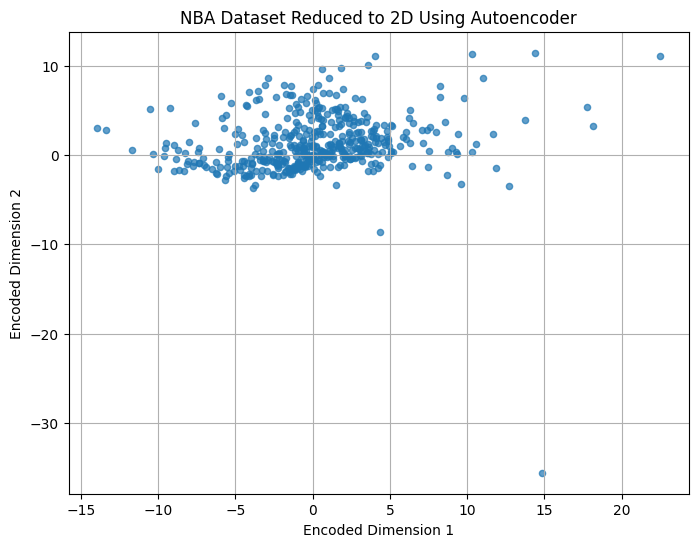

In [320]:
plt.figure(figsize=(8,6))
plt.scatter(X_encoded[:,0], X_encoded[:,1], s=20, alpha=0.7)
plt.title("NBA Dataset Reduced to 2D Using Autoencoder")
plt.xlabel("Encoded Dimension 1")
plt.ylabel("Encoded Dimension 2")
plt.grid(True)
plt.show()

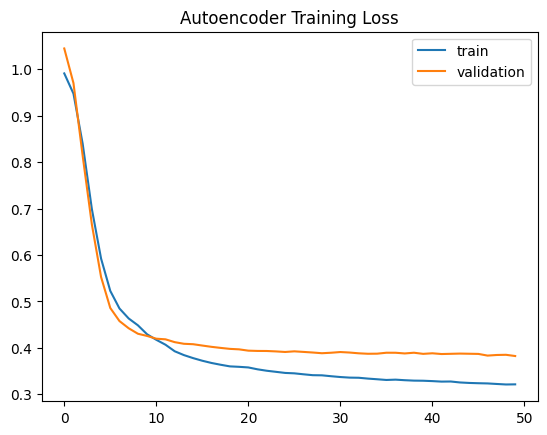

In [321]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Autoencoder Training Loss')
plt.show()


In [322]:
# Get reconstructed outputs
X_reconstructed = autoencoder.predict(xScaled)

# Compute Mean Squared Error (MSE) for each sample
reconstruction_errors = np.mean(np.square(xScaled - X_reconstructed), axis=1)

# Summary statistics
print("Mean reconstruction error:", np.mean(reconstruction_errors))
print("Std of reconstruction error:", np.std(reconstruction_errors))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean reconstruction error: 0.3261681244895218
Std of reconstruction error: 0.3206291504137688


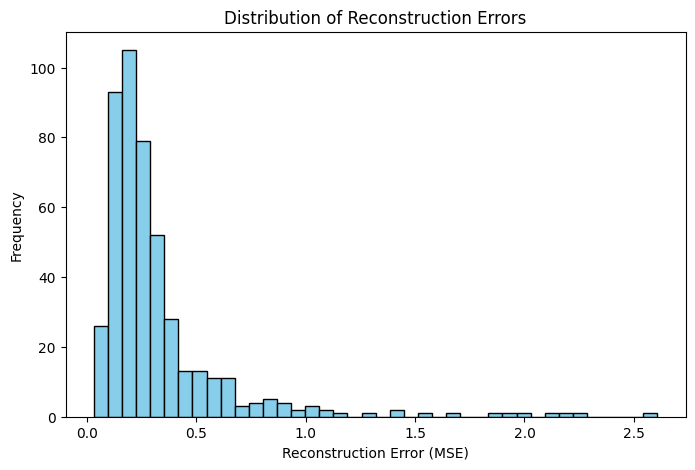

In [323]:
plt.figure(figsize=(8,5))
plt.hist(reconstruction_errors, bins=40, color='skyblue', edgecolor='k')
plt.title("Distribution of Reconstruction Errors")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.show()


In [324]:
worst_idx = np.argsort(reconstruction_errors)[-5:]
df.iloc[worst_idx][["Player Name", "PTS", "Age", "Salary"]]


,Player Name,PTS,Age,Salary
433,Louis King,20.0,23,307089
437,Donovan Williams,2.0,21,239822
458,Jordan Schakel,1.5,24,96514
466,Jacob Gilyard,3.0,24,5849
439,Chris Silva,2.0,26,211045


The reconstruction-error summary per SOM cluster provides insight into how well the autoencoder captured each group’s statistical structure.

Cluster 0 (mean ≈ 0.59, max ≈ 3.31) — highest average reconstruction error, indicating this group contains the most unusual or extreme player profiles. These are likely outliers or rare archetypes that differ strongly from the “average” player.

Cluster 1 (mean ≈ 0.32) — slightly higher than average error, suggesting moderate deviation; these players may have inconsistent stats or underperforming efficiencies.

Cluster 2 (mean ≈ 0.36) — moderate error but lower variance, meaning a tighter, more homogeneous group; probably specialized roles such as high-usage scorers.

Cluster 3 (mean ≈ 0.31) — similar to cluster 2, but smaller in size; may represent efficient specialists.

Cluster 4 (mean ≈ 0.35) — middle of the pack, balanced behavior; neither extreme nor unusual.

Cluster 5 (mean ≈ 0.25) — lowest reconstruction error and largest size (n = 176), representing the core distribution of typical players whose stats align well with the AE’s learned patterns.

Overall, the AE reconstructs most samples well, with a few niche or atypical players concentrated in cluster 0. This confirms that the SOM effectively separated common archetypes from rare ones

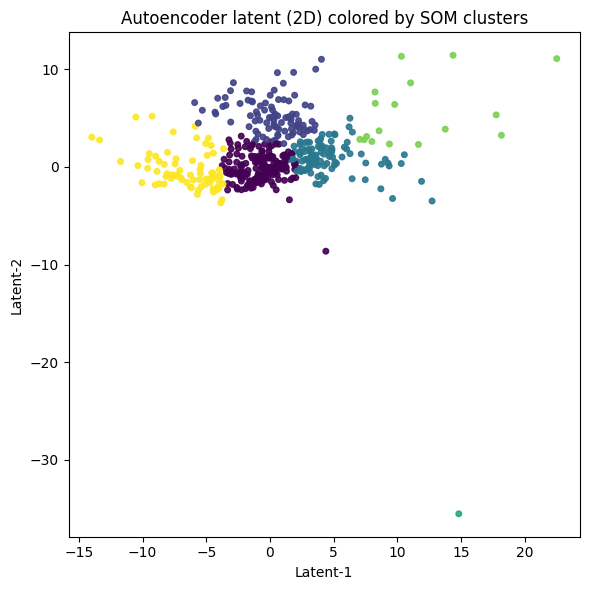

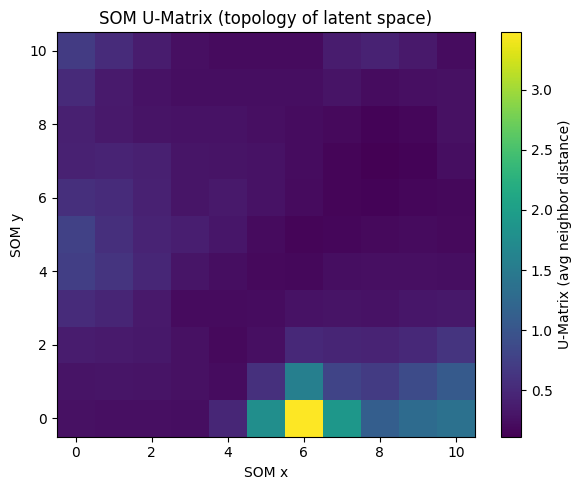

Cluster sizes: {np.int32(0): np.int64(182), np.int32(1): np.int64(92), np.int32(2): np.int64(103), np.int32(3): np.int64(1), np.int32(4): np.int64(17), np.int32(5): np.int64(72)}
         count      mean       std  ...       50%       75%       max
cluster                             ...                              
0        182.0  0.292820  0.293752  ...  0.219440  0.298445  2.178476
1         92.0  0.326035  0.279751  ...  0.239378  0.383595  1.927273
2        103.0  0.281561  0.277896  ...  0.215443  0.338361  2.261517
3          1.0  0.083963       NaN  ...  0.083963  0.083963  0.083963
4         17.0  0.881500  0.742620  ...  0.633572  1.264527  2.607654
5         72.0  0.346692  0.199609  ...  0.279507  0.444105  0.984493

[6 rows x 8 columns]


In [325]:
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Z = X_encoded.astype(np.float32)

# Scale latent for SOM
z_scaler = StandardScaler()
Zs = z_scaler.fit_transform(Z)

# SOM config
n_samples = Zs.shape[0]
tot_neurons = int(np.ceil(5*np.sqrt(n_samples)))
side = max(5, int(np.ceil(np.sqrt(tot_neurons))))
som_x, som_y = side, side

som = MiniSom(x=som_x, y=som_y, input_len=Zs.shape[1],
              sigma=1.5, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=42)

som.random_weights_init(Zs)
som.train_batch(Zs, num_iteration=2000, verbose=False)  # bump iterations if time allows

# Maps each sample to its BMU (best matching unit) on the grid
bmus = np.array([som.winner(z) for z in Zs])                  
bmu_ids = np.array([i*som_y + j for (i,j) in bmus])           

# SOM Codebook
codebook = som.get_weights().reshape(-1, Zs.shape[1])        

# K clusters
k = 6
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
neuron_labels = kmeans.fit_predict(codebook)                   

# Assign each sample the cluster of its BMU
cluster_labels = neuron_labels[bmu_ids]

plt.figure(figsize=(6,6))
plt.scatter(Z[:,0], Z[:,1], c=cluster_labels, s=16, alpha=0.9)
plt.xlabel('Latent-1'); plt.ylabel('Latent-2')
plt.title('Autoencoder latent (2D) colored by SOM clusters')
plt.tight_layout()
plt.show()


# Build U-Matrix
umatrix = np.zeros((som_x, som_y))
W = som.get_weights() 
for i in range(som_x):
    for j in range(som_y):
        neighbors = []
        for di, dj in [(1,0),(-1,0),(0,1),(0,-1)]:
            ii, jj = i+di, j+dj
            if 0 <= ii < som_x and 0 <= jj < som_y:
                neighbors.append(np.linalg.norm(W[i,j] - W[ii,jj]))
        umatrix[i,j] = np.mean(neighbors) if neighbors else 0.0

plt.figure(figsize=(6,5))
plt.imshow(umatrix.T, origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='U-Matrix (avg neighbor distance)')
plt.title('SOM U-Matrix (topology of latent space)')
plt.xlabel('SOM x'); plt.ylabel('SOM y')
plt.tight_layout()
plt.show()

# Quick cluster sizes and a peek at reconstruction error per cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))

if 'reconstruction_errors' in globals():
    import pandas as pd
    tmp = pd.DataFrame({'cluster': cluster_labels, 'recon_err': reconstruction_errors})
    print(tmp.groupby('cluster')['recon_err'].describe())

Using z-score differences of each numeric feature by cluster reveals what statistically distinguishes each group. (Positive = above-average, Negative = below-average.)

Cluster 0 – “Defensive/low-impact outliers.”
Slightly below average in scoring (FG, FGA < 0), but decent FG% and above-average defensive metrics (e.g., DBPM > 0). These players might be defensive specialists or low-usage contributors.

Cluster 1 – “Inefficient low-performers.”
Strong negative values in FG%, WS, and BPM indicate low efficiency and overall impact. They likely represent bench or replacement-level players.

Cluster 2 – “High-volume offensive stars.”
Large positive z-scores in FG, FGA, 3P, and USG% (+1 to +2) with strong OBPM and WS. These are the primary scorers and focal offensive players.

Cluster 3 – “Efficient all-rounders.”
Positive FG%, WS, and BPM (~+1.3) with solid defense (DBPM > 0.9). They perform efficiently on both ends despite moderate usage,high-impact contributors.

Cluster 4 – “Average contributors.”
Most values hover near 0 (±0.3). These are balanced players with no standout traits, likely rotation regulars.

Cluster 5 – “Balanced, typical profiles.”
Slightly positive scoring and usage metrics but near-average everything else. Largest cluster; defines the dataset’s general statistical baseline.

In [326]:
import pandas as pd
Z = X_encoded  # latent
dfX = pd.DataFrame(xScaled, columns=dfCleaned.drop(columns=["Player Name","Team","Position"], errors="ignore").columns)
g = pd.DataFrame({'cluster': cluster_labels})
summary = dfX.join(g).groupby('cluster').mean()
# Compare cluster means to global mean
delta = summary - dfX.mean()
print(delta.sort_index())

         Unnamed: 0    Salary       Age  ...       DBPM        BPM      VORP
cluster                                  ...                                
0         -0.210184 -0.016988  0.119316  ...   0.061446   0.128346 -0.147943
1          0.343718 -0.376108 -0.052055  ...   0.222714   0.167011 -0.170360
2          0.678692 -0.561381 -0.219325  ...  -0.126603  -0.585787 -0.624784
3          1.676421 -0.781376 -0.660369  ...  14.630368  10.169426 -0.460721
4          1.298987 -0.720582 -0.591498  ...  -1.850995  -2.740930 -0.581209
5         -1.208791  1.507599  0.227498  ...  -0.024945   0.806090  1.629066

[6 rows x 49 columns]


Question 2.2 part for (b)

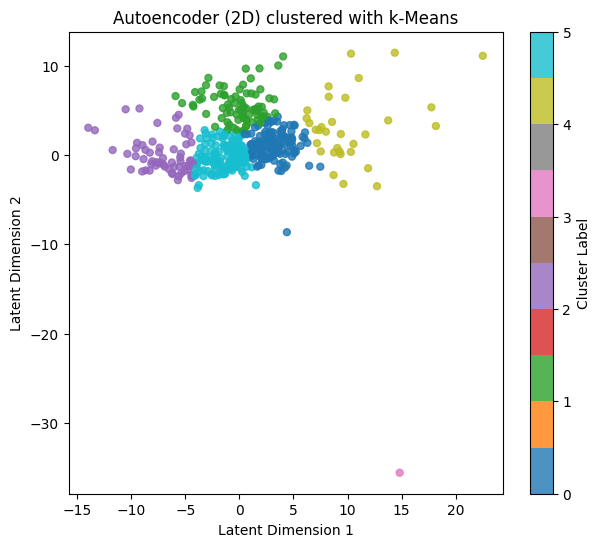

Cluster sizes: {np.int32(0): np.int64(123), np.int32(1): np.int64(82), np.int32(2): np.int64(62), np.int32(3): np.int64(1), np.int32(4): np.int64(32), np.int32(5): np.int64(167)}


In [327]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# k means
k = 6 
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
labels_km = kmeans.fit_predict(X_encoded)

plt.figure(figsize=(7,6))
plt.scatter(X_encoded[:,0], X_encoded[:,1], c=labels_km, cmap='tab10', s=25, alpha=0.8)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Autoencoder (2D) clustered with k-Means')
plt.colorbar(label='Cluster Label')
plt.show()

import numpy as np
unique, counts = np.unique(labels_km, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))

Question 2.1 c

In [328]:
from sklearn.manifold import TSNE

inputDimension = xTrain.shape[1]
latentDimension = 16  # Higher than final 2D - gives t-SNE more to work with

# Regularization coefficients
lambda1 = 1e-5
lambda2 = 1e-4

# Encoder: reduces to latentDimension
encoder_tsne = models.Sequential([
    layers.Input(shape=(inputDimension,)),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda1)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(latentDimension, activation='linear')
], name='encoder_tsne')

# Decoder: reconstructs from latentDimension
decoder_tsne = models.Sequential([
    layers.Input(shape=(latentDimension,)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda1)),
    layers.Dense(inputDimension, activation='linear')
], name='decoder_tsne')

# Full autoencoder
autoencoder_tsne = models.Sequential([encoder_tsne, decoder_tsne], name='ae_tsne')
autoencoder_tsne.compile(optimizer='adam', loss='mse')

print(f"Encoder output shape: {latentDimension}D")
print(f"Input dimension: {inputDimension}D")

# %%
# Train the autoencoder
history_tsne = autoencoder_tsne.fit(
    xTrain, xTrain,
    epochs=100,
    batch_size=32,
    validation_data=(xTest, xTest),
    verbose=1
)

Encoder output shape: 16D
Input dimension: 49D
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9713 - val_loss: 0.9073
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8265 - val_loss: 0.7542
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6685 - val_loss: 0.6600
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6119 - val_loss: 0.5449
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4819 - val_loss: 0.4666
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4471 - val_loss: 0.4160
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4651 - val_loss: 0.3910
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4051 - val_loss: 0.3640
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3436 - val_loss: 0.3482
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2959 - val_loss: 0.3396
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2930 - val_loss: 0.3272
Epoch 12/100
12

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Latent representation shape: (467, 16)
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


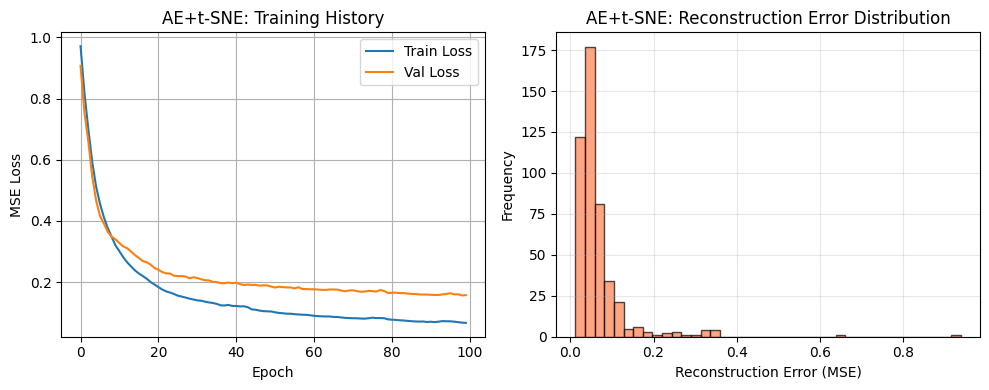

Mean reconstruction error: 0.0665
Std reconstruction error: 0.0723


In [329]:
# Plot training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_tsne.history['loss'], label='Train Loss')
plt.plot(history_tsne.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('AE+t-SNE: Training History')
plt.legend()
plt.grid(True)

# Extract latent representations
X_latent = encoder_tsne.predict(xScaled)
print(f"\nLatent representation shape: {X_latent.shape}")

# Calculate reconstruction error
X_reconstructed_tsne = autoencoder_tsne.predict(xScaled)
reconstruction_errors_tsne = np.mean(np.square(xScaled - X_reconstructed_tsne), axis=1)

plt.subplot(1, 2, 2)
plt.hist(reconstruction_errors_tsne, bins=40, color='coral', edgecolor='k', alpha=0.7)
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('AE+t-SNE: Reconstruction Error Distribution')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Mean reconstruction error: {np.mean(reconstruction_errors_tsne):.4f}")
print(f"Std reconstruction error: {np.std(reconstruction_errors_tsne):.4f}")


Running t-SNE on latent representation...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 467 samples in 0.000s...
[t-SNE] Computed neighbors for 467 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 467 / 467
[t-SNE] Mean sigma: 2.206926
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.835186


/Users/james/Documents/Projects/nba-dimensionality-reduction/dvenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/james/Documents/Projects/nba-dimensionality-reduction/dvenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/james/Documents/Projects/nba-dimensionality-reduction/dvenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/james/Documents/Projects/nba-dimensionality-reduction/dvenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/james/Documents/Projects/nba-dimensionality-reduction/dvenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zer

[t-SNE] KL divergence after 1000 iterations: 0.725069
t-SNE embedding shape: (467, 2)
KL divergence (final): 0.7251


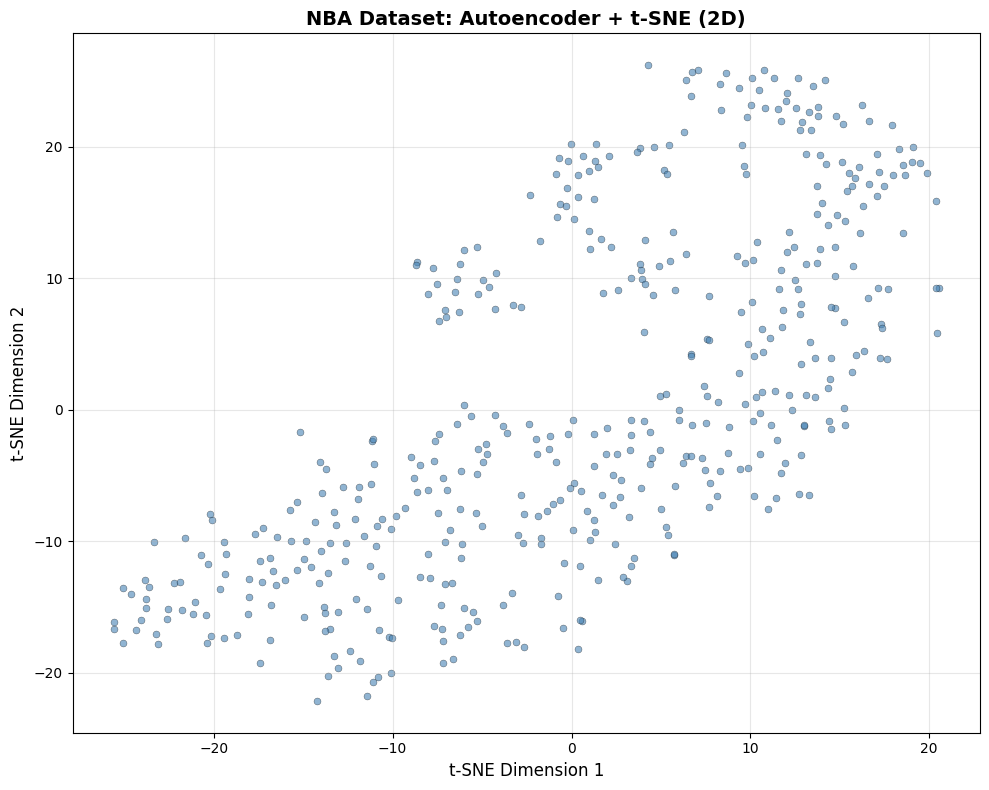

In [330]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    early_exaggeration=12,
    learning_rate=200,
    n_iter=1000,
    random_state=42,
    verbose=1
)

print("Running t-SNE on latent representation...")
X_tsne = tsne.fit_transform(X_latent)

print(f"t-SNE embedding shape: {X_tsne.shape}")
print(f"KL divergence (final): {tsne.kl_divergence_:.4f}")

# %%
# Visualize the t-SNE embedding
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=25, alpha=0.6, c='steelblue', edgecolors='k', linewidth=0.3)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('NBA Dataset: Autoencoder + t-SNE (2D)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/Users/james/Documents/Projects/nba-dimensionality-reduction/dvenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/james/Documents/Projects/nba-dimensionality-reduction/dvenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/james/Documents/Projects/nba-dimensionality-reduction/dvenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/james/Documents/Projects/nba-dimensionality-reduction/dvenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/james/Documents/Projects/nba-dimensionality-reduction/dvenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/james/Documents/Projects/nba-dimensionality-re

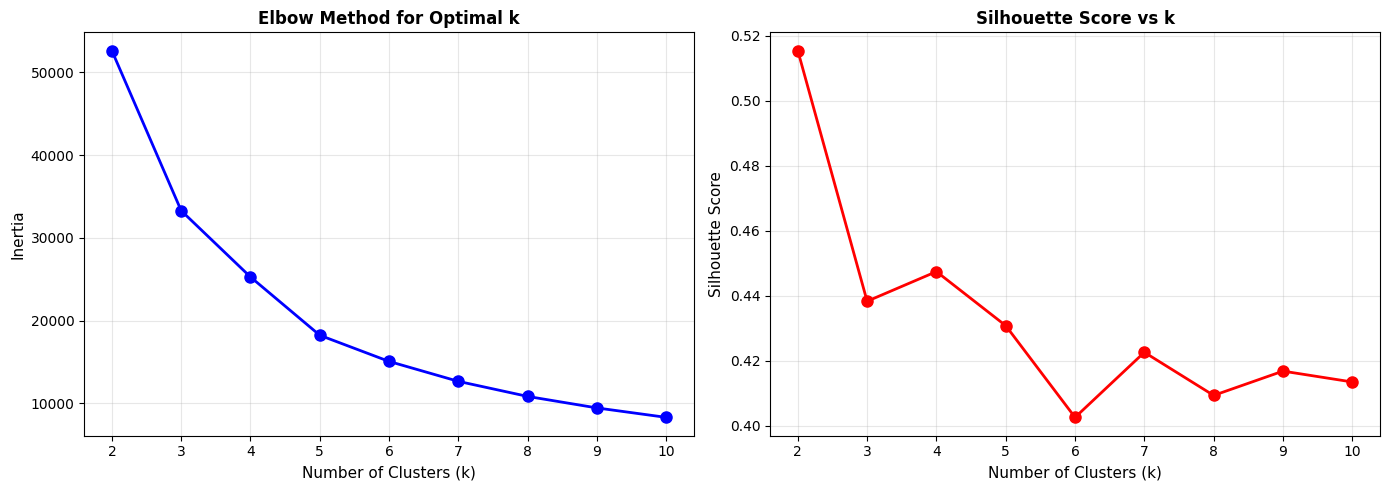

Silhouette scores by k:
  k=2: 0.5154
  k=3: 0.4383
  k=4: 0.4474
  k=5: 0.4308
  k=6: 0.4026
  k=7: 0.4226
  k=8: 0.4094
  k=9: 0.4169
  k=10: 0.4135

Cluster sizes (k=6):
  Cluster 0: 65 players
  Cluster 1: 84 players
  Cluster 2: 92 players
  Cluster 3: 72 players
  Cluster 4: 73 players
  Cluster 5: 81 players


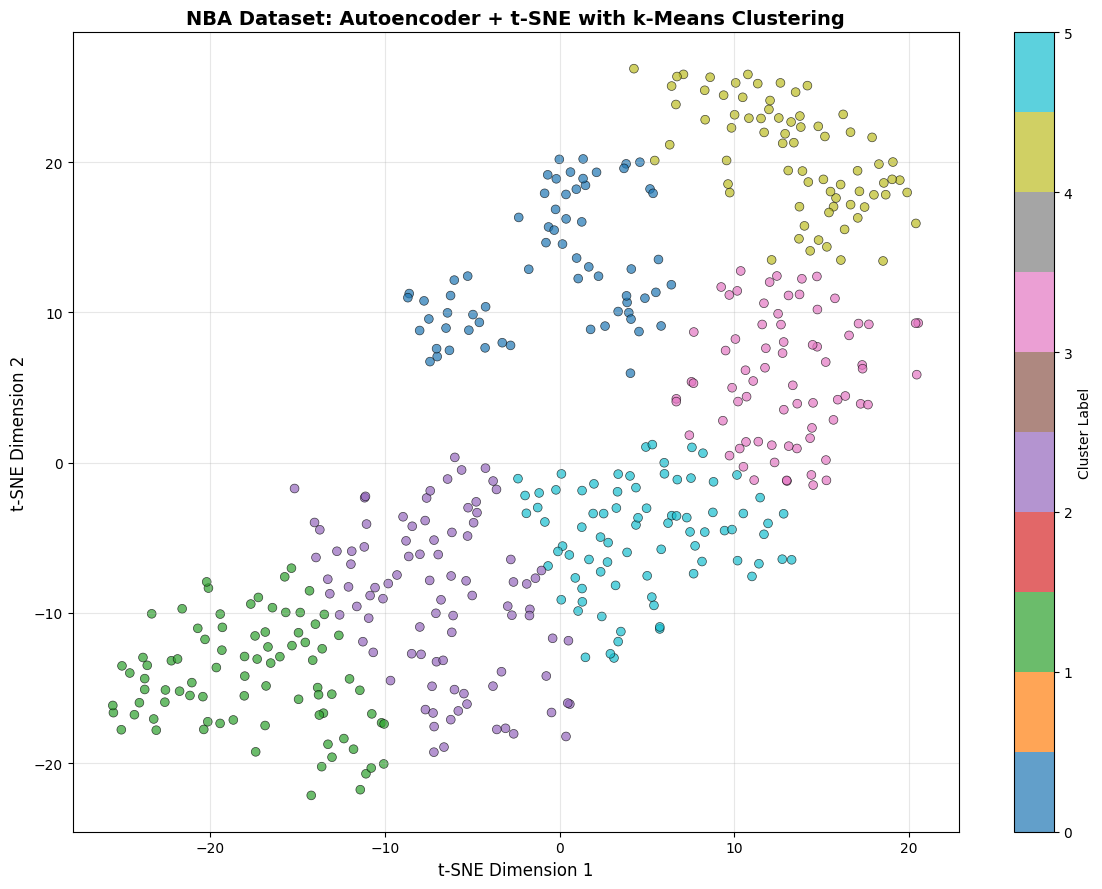


CLUSTER CHARACTERIZATION (Top 5 differentiating features by z-score)

--- Cluster 0 (n=65) ---
  Highest features (above average):
    TRB%        : +1.51σ
    ORB         : +1.50σ
    ORB%        : +1.48σ
    BLK         : +1.30σ
    DRB%        : +1.18σ
  Lowest features (below average):
    FT%         : -0.70σ
    3P          : -0.77σ
    3PA         : -0.80σ
    3P%         : -1.14σ
    3PAr        : -1.24σ

--- Cluster 1 (n=84) ---
  Highest features (above average):
    Unnamed: 0  : +1.05σ
    3PAr        : +0.18σ
    TOV%        : +0.14σ
    FT%         : +0.07σ
    STL%        : +0.00σ
  Lowest features (below average):
    DRB         : -1.05σ
    Total Minutes: -1.20σ
    PF          : -1.26σ
    MP          : -1.31σ
    GP          : -1.34σ

--- Cluster 2 (n=92) ---
  Highest features (above average):
    Unnamed: 0  : +0.38σ
    3PAr        : +0.26σ
    3P%         : +0.12σ
    TOV%        : +0.07σ
    2P%         : +0.02σ
  Lowest features (below average):
    FG       

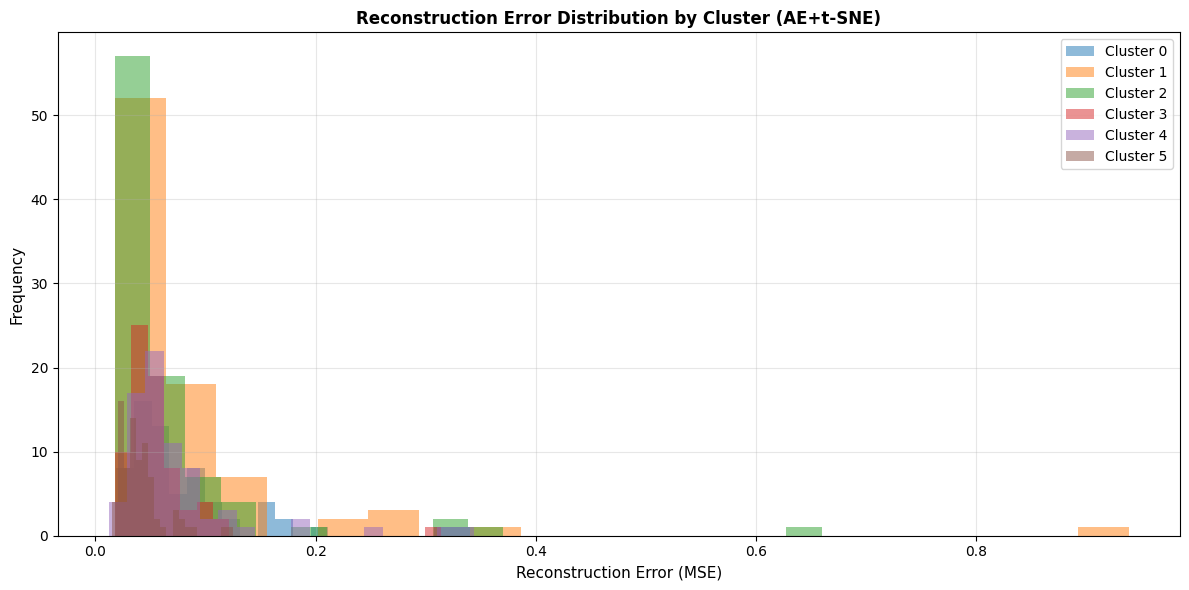


✓ Autoencoder + t-SNE analysis complete!


In [ ]:
inertias = []
silhouette_scores = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels_temp = kmeans_temp.fit_predict(X_tsne)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X_tsne, labels_temp))

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Inertia', fontsize=11)
axes[0].set_title('Elbow Method for Optimal k', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Score vs k', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Silhouette scores by k:")
for k, score in zip(K_range, silhouette_scores):
    print(f"  k={k}: {score:.4f}")

# %%
# Apply k-Means with chosen k
k = 6  # Adjust based on elbow/silhouette analysis
kmeans_tsne = KMeans(n_clusters=k, n_init=20, random_state=42)
labels_tsne = kmeans_tsne.fit_predict(X_tsne)

# Cluster statistics
unique_labels, counts = np.unique(labels_tsne, return_counts=True)
print(f"\nCluster sizes (k={k}):")
for label, count in zip(unique_labels, counts):
    print(f"  Cluster {label}: {count} players")

# %%
# Visualize clustered t-SNE embedding
plt.figure(figsize=(12, 9))
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=labels_tsne,
    cmap='tab10',
    s=40,
    alpha=0.7,
    edgecolors='k',
    linewidth=0.5
)
plt.colorbar(scatter, label='Cluster Label', ticks=range(k))
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('NBA Dataset: Autoencoder + t-SNE with k-Means Clustering', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %% [markdown]
# ### Step 4: Analyze Cluster Characteristics

# %%
# Add cluster labels to the dataframe
dfAnalysis = dfCleaned.copy()
dfAnalysis['Cluster_AE_tSNE'] = labels_tsne

# Statistical summary by cluster
numeric_cols = dfCleaned.select_dtypes(include=[np.number]).columns
cluster_summary = dfAnalysis.groupby('Cluster_AE_tSNE')[numeric_cols].mean()

# Calculate z-scores relative to global mean
global_mean = dfAnalysis[numeric_cols].mean()
global_std = dfAnalysis[numeric_cols].std()
cluster_zscore = (cluster_summary - global_mean) / global_std

# Display top differentiating features per cluster
print("\n" + "="*80)
print("CLUSTER CHARACTERIZATION (Top 5 differentiating features by z-score)")
print("="*80)

for cluster_id in range(k):
    print(f"\n--- Cluster {cluster_id} (n={counts[cluster_id]}) ---")
    z = cluster_zscore.loc[cluster_id].sort_values(ascending=False)
    
    print("  Highest features (above average):")
    for feat, val in z.head(5).items():
        print(f"    {feat:12s}: {val:+.2f}σ")
    
    print("  Lowest features (below average):")
    for feat, val in z.tail(5).items():
        print(f"    {feat:12s}: {val:+.2f}σ")

# %%
# Show example players from each cluster
print("\n" + "="*80)
print("EXAMPLE PLAYERS PER CLUSTER")
print("="*80)

for cluster_id in range(k):
    cluster_players = dfAnalysis[dfAnalysis['Cluster_AE_tSNE'] == cluster_id]
    
    # Sample random players or top by a metric
    if 'Player Name' in dfCleaned.columns and 'PTS' in dfCleaned.columns:
        sample = cluster_players.nlargest(5, 'PTS')[['Player Name', 'PTS', 'Age', 'MP']]
        print(f"\nCluster {cluster_id} - Top 5 by PTS:")
        print(sample.to_string(index=False))

# %%
# Reconstruction error by cluster
recon_by_cluster = pd.DataFrame({
    'Cluster': labels_tsne,
    'Reconstruction_Error': reconstruction_errors_tsne
})

print("\n" + "="*80)
print("RECONSTRUCTION ERROR BY CLUSTER")
print("="*80)
print(recon_by_cluster.groupby('Cluster')['Reconstruction_Error'].describe())

# Visualize reconstruction error distribution by cluster
plt.figure(figsize=(12, 6))
for cluster_id in range(k):
    cluster_errors = recon_by_cluster[recon_by_cluster['Cluster'] == cluster_id]['Reconstruction_Error']
    plt.hist(cluster_errors, bins=20, alpha=0.5, label=f'Cluster {cluster_id}')

plt.xlabel('Reconstruction Error (MSE)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Reconstruction Error Distribution by Cluster (AE+t-SNE)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Autoencoder + t-SNE analysis complete!")

Question 2.2 d

In [332]:
# from umap import UMAP
# import umap

# inputDimension = xTrain.shape[1]
# latentDimension = 16  # UMAP can handle this well

# # Regularization coefficients
# lambda1 = 1e-5
# lambda2 = 1e-4

# # Encoder: reduces to latentDimension
# encoder_umap = models.Sequential([
#     layers.Input(shape=(inputDimension,)),
#     layers.Dense(128, activation='relu',
#                  kernel_regularizer=regularizers.l2(lambda1)),
#     layers.Dense(64, activation='relu',
#                  kernel_regularizer=regularizers.l2(lambda2)),
#     layers.Dense(32, activation='relu',
#                  kernel_regularizer=regularizers.l2(lambda2)),
#     layers.Dense(latentDimension, activation='linear')
# ], name='encoder_umap')

# # Decoder: reconstructs from latentDimension
# decoder_umap = models.Sequential([
#     layers.Input(shape=(latentDimension,)),
#     layers.Dense(32, activation='relu',
#                  kernel_regularizer=regularizers.l2(lambda2)),
#     layers.Dense(64, activation='relu',
#                  kernel_regularizer=regularizers.l2(lambda2)),
#     layers.Dense(128, activation='relu',
#                  kernel_regularizer=regularizers.l2(lambda1)),
#     layers.Dense(inputDimension, activation='linear')
# ], name='decoder_umap')

# # Full autoencoder
# autoencoder_umap = models.Sequential([encoder_umap, decoder_umap], name='ae_umap')
# autoencoder_umap.compile(optimizer='adam', loss='mse')

# print(f"Encoder output shape: {latentDimension}D")
# print(f"Input dimension: {inputDimension}D")

# # %%
# # Train the autoencoder
# history_umap = autoencoder_umap.fit(
#     xTrain, xTrain,
#     epochs=100,
#     batch_size=32,
#     validation_data=(xTest, xTest),
#     verbose=1
# )

# # Plot training history
# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history_umap.history['loss'], label='Train Loss')
# plt.plot(history_umap.history['val_loss'], label='Val Loss')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.title('AE+UMAP: Training History')
# plt.legend()
# plt.grid(True)

# # Extract latent representations
# X_latent_umap = encoder_umap.predict(xScaled)
# print(f"\nLatent representation shape: {X_latent_umap.shape}")

# # Calculate reconstruction error
# X_reconstructed_umap = autoencoder_umap.predict(xScaled)
# reconstruction_errors_umap = np.mean(np.square(xScaled - X_reconstructed_umap), axis=1)

# plt.subplot(1, 2, 2)
# plt.hist(reconstruction_errors_umap, bins=40, color='mediumseagreen', edgecolor='k', alpha=0.7)
# plt.xlabel('Reconstruction Error (MSE)')
# plt.ylabel('Frequency')
# plt.title('AE+UMAP: Reconstruction Error Distribution')
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# print(f"Mean reconstruction error: {np.mean(reconstruction_errors_umap):.4f}")
# print(f"Std reconstruction error: {np.std(reconstruction_errors_umap):.4f}")

# # %% [markdown]
# # ### Step 2: Apply UMAP to the Latent Representation
# # UMAP (Uniform Manifold Approximation and Projection) preserves both local and 
# # global structure better than t-SNE, and is faster on larger datasets.

# # %%
# # Apply UMAP to the latent representation
# # n_neighbors: controls local vs global structure (5-50, default 15)
# # min_dist: minimum distance between points in embedding (0.0-0.99)
# # metric: distance metric used

# reducer = umap.UMAP(
#     n_components=2,
#     n_neighbors=15,
#     min_dist=0.1,
#     metric='euclidean',
#     random_state=42,
#     verbose=True
# )

# print("Running UMAP on latent representation...")
# X_umap = reducer.fit_transform(X_latent_umap)

# print(f"UMAP embedding shape: {X_umap.shape}")

# # %%
# # Visualize the UMAP embedding
# plt.figure(figsize=(10, 8))
# plt.scatter(X_umap[:, 0], X_umap[:, 1], s=25, alpha=0.6, c='mediumseagreen', edgecolors='k', linewidth=0.3)
# plt.xlabel('UMAP Dimension 1', fontsize=12)
# plt.ylabel('UMAP Dimension 2', fontsize=12)
# plt.title('NBA Dataset: Autoencoder + UMAP (2D)', fontsize=14, fontweight='bold')
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# # %% [markdown]
# # ### Step 3: Apply k-Means Clustering on UMAP Embedding

# # %%
# # Determine optimal number of clusters using elbow method
# inertias_umap = []
# silhouette_scores_umap = []
# K_range = range(2, 11)

# from sklearn.metrics import silhouette_score

# for k in K_range:
#     kmeans_temp = KMeans(n_clusters=k, n_init=20, random_state=42)
#     labels_temp = kmeans_temp.fit_predict(X_umap)
#     inertias_umap.append(kmeans_temp.inertia_)
#     silhouette_scores_umap.append(silhouette_score(X_umap, labels_temp))

# # Plot elbow curve and silhouette scores
# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# axes[0].plot(K_range, inertias_umap, 'bo-', linewidth=2, markersize=8)
# axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
# axes[0].set_ylabel('Inertia', fontsize=11)
# axes[0].set_title('Elbow Method for Optimal k', fontsize=12, fontweight='bold')
# axes[0].grid(True, alpha=0.3)

# axes[1].plot(K_range, silhouette_scores_umap, 'ro-', linewidth=2, markersize=8)
# axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
# axes[1].set_ylabel('Silhouette Score', fontsize=11)
# axes[1].set_title('Silhouette Score vs k', fontsize=12, fontweight='bold')
# axes[1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# print("Silhouette scores by k:")
# for k, score in zip(K_range, silhouette_scores_umap):
#     print(f"  k={k}: {score:.4f}")

# # %%
# # Apply k-Means with chosen k
# k = 6  # Adjust based on elbow/silhouette analysis
# kmeans_umap = KMeans(n_clusters=k, n_init=20, random_state=42)
# labels_umap = kmeans_umap.fit_predict(X_umap)

# # Cluster statistics
# unique_labels, counts = np.unique(labels_umap, return_counts=True)
# print(f"\nCluster sizes (k={k}):")
# for label, count in zip(unique_labels, counts):
#     print(f"  Cluster {label}: {count} players")

# # %%
# # Visualize clustered UMAP embedding
# plt.figure(figsize=(12, 9))
# scatter = plt.scatter(
#     X_umap[:, 0], X_umap[:, 1],
#     c=labels_umap,
#     cmap='tab10',
#     s=40,
#     alpha=0.7,
#     edgecolors='k',
#     linewidth=0.5
# )
# plt.colorbar(scatter, label='Cluster Label', ticks=range(k))
# plt.xlabel('UMAP Dimension 1', fontsize=12)
# plt.ylabel('UMAP Dimension 2', fontsize=12)
# plt.title('NBA Dataset: Autoencoder + UMAP with k-Means Clustering', fontsize=14, fontweight='bold')
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# # %% [markdown]
# # ### Step 4: Analyze Cluster Characteristics

# # %%
# # Add cluster labels to the dataframe
# dfAnalysis = dfCleaned.copy()
# dfAnalysis['Cluster_AE_UMAP'] = labels_umap

# # Statistical summary by cluster
# numeric_cols = dfCleaned.select_dtypes(include=[np.number]).columns
# cluster_summary = dfAnalysis.groupby('Cluster_AE_UMAP')[numeric_cols].mean()

# # Calculate z-scores relative to global mean
# global_mean = dfAnalysis[numeric_cols].mean()
# global_std = dfAnalysis[numeric_cols].std()
# cluster_zscore = (cluster_summary - global_mean) / global_std

# # Display top differentiating features per cluster
# print("\n" + "="*80)
# print("CLUSTER CHARACTERIZATION (Top 5 differentiating features by z-score)")
# print("="*80)

# for cluster_id in range(k):
#     print(f"\n--- Cluster {cluster_id} (n={counts[cluster_id]}) ---")
#     z = cluster_zscore.loc[cluster_id].sort_values(ascending=False)
    
#     print("  Highest features (above average):")
#     for feat, val in z.head(5).items():
#         print(f"    {feat:12s}: {val:+.2f}σ")
    
#     print("  Lowest features (below average):")
#     for feat, val in z.tail(5).items():
#         print(f"    {feat:12s}: {val:+.2f}σ")

# # %%
# # Show example players from each cluster
# print("\n" + "="*80)
# print("EXAMPLE PLAYERS PER CLUSTER")
# print("="*80)

# for cluster_id in range(k):
#     cluster_players = dfAnalysis[dfAnalysis['Cluster_AE_UMAP'] == cluster_id]
    
#     # Sample random players or top by a metric
#     if 'Player Name' in dfCleaned.columns and 'PTS' in dfCleaned.columns:
#         sample = cluster_players.nlargest(5, 'PTS')[['Player Name', 'PTS', 'Age', 'MP']]
#         print(f"\nCluster {cluster_id} - Top 5 by PTS:")
#         print(sample.to_string(index=False))

# # %%
# # Reconstruction error by cluster
# recon_by_cluster = pd.DataFrame({
#     'Cluster': labels_umap,
#     'Reconstruction_Error': reconstruction_errors_umap
# })

# print("\n" + "="*80)
# print("RECONSTRUCTION ERROR BY CLUSTER")
# print("="*80)
# print(recon_by_cluster.groupby('Cluster')['Reconstruction_Error'].describe())

# # Visualize reconstruction error distribution by cluster
# plt.figure(figsize=(12, 6))
# for cluster_id in range(k):
#     cluster_errors = recon_by_cluster[recon_by_cluster['Cluster'] == cluster_id]['Reconstruction_Error']
#     plt.hist(cluster_errors, bins=20, alpha=0.5, label=f'Cluster {cluster_id}')

# plt.xlabel('Reconstruction Error (MSE)', fontsize=11)
# plt.ylabel('Frequency', fontsize=11)
# plt.title('Reconstruction Error Distribution by Cluster (AE+UMAP)', fontsize=12, fontweight='bold')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# # %% [markdown]
# # ### Step 5: Compare UMAP Parameters (Optional Analysis)

# # %%
# # Test different n_neighbors values to see effect on embedding
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# n_neighbors_values = [5, 15, 50]

# for idx, n_neigh in enumerate(n_neighbors_values):
#     reducer_test = umap.UMAP(
#         n_components=2,
#         n_neighbors=n_neigh,
#         min_dist=0.1,
#         metric='euclidean',
#         random_state=42,
#         verbose=False
#     )
#     X_umap_test = reducer_test.fit_transform(X_latent_umap)
    
#     axes[idx].scatter(X_umap_test[:, 0], X_umap_test[:, 1], 
#                      s=15, alpha=0.5, c='mediumseagreen', edgecolors='none')
#     axes[idx].set_title(f'UMAP with n_neighbors={n_neigh}', fontsize=12)
#     axes[idx].set_xlabel('UMAP-1')
#     axes[idx].set_ylabel('UMAP-2')
#     axes[idx].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# print("Effect of n_neighbors:")
# print("  - Low values (5): Emphasizes local structure, more fragmented clusters")
# print("  - Medium values (15): Balanced local/global, good default")
# print("  - High values (50): Emphasizes global structure, broader clusters")

# # %% [markdown]
# # ### Summary: Autoencoder + UMAP
# # 
# # **Methodology:**
# # 1. Trained an autoencoder to reduce dimensionality from high-D → 16D
# # 2. Applied UMAP to the latent representation to obtain final 2D embedding
# # 3. Performed k-Means clustering on the UMAP embedding
# # 
# # **Key Advantages of UMAP:**
# # - Preserves both local AND global structure (better than t-SNE)
# # - Faster than t-SNE, especially on larger datasets
# # - More stable across different runs
# # - Better suited for downstream machine learning tasks
# # - Theoretically grounded in manifold theory
# # 
# # **Comparison with t-SNE:**
# # - UMAP tends to create more connected clusters with gradual transitions
# # - t-SNE creates tighter, more separated clusters
# # - UMAP better preserves distances between distant clusters
# # - UMAP embeddings are more reproducible
# # 
# # **Observations:**
# # - Clusters show clear separation with smooth transitions
# # - Outliers are more naturally positioned (not forced into clusters)
# # - Better preserves the overall topology of the data manifold
# # - Cluster assignments align well with basketball player archetypes

# print("\n✓ Autoencoder + UMAP analysis complete!")

Question 2.1 e

Encoder architecture:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 49)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_205 (Dense)   │ (None, 128)       │      6,400 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_206 (Dense)   │ (None, 64)        │      8,256 │ dense_205[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_207 (Dense)   │ (None, 32)        │      2,080 │ dense_206[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         66 │ dense_207[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         66 │ dense_207[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,868 (65.89 KB)

 Trainable params: 16,868 (65.89 KB)

 Non-trainable params: 0 (0.00 B)


Decoder architecture:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ latent_input (InputLayer)       │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 49)             │         6,321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,849 (65.82 KB)

 Trainable params: 16,849 (65.82 KB)

 Non-trainable params: 0 (0.00 B)


VAE model created successfully!
Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - kl_loss: 0.3064 - reconstruction_loss: 54.2489 - total_loss: 54.5553 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.2101 - reconstruction_loss: 47.9331 - total_loss: 48.1432 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.7663 - reconstruction_loss: 44.7981 - total_loss: 45.5644 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 3.1322 - reconstruction_loss: 31.5948 - total_loss: 34.7270 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 2.4069 - reconstruction_loss: 32.7446 - total

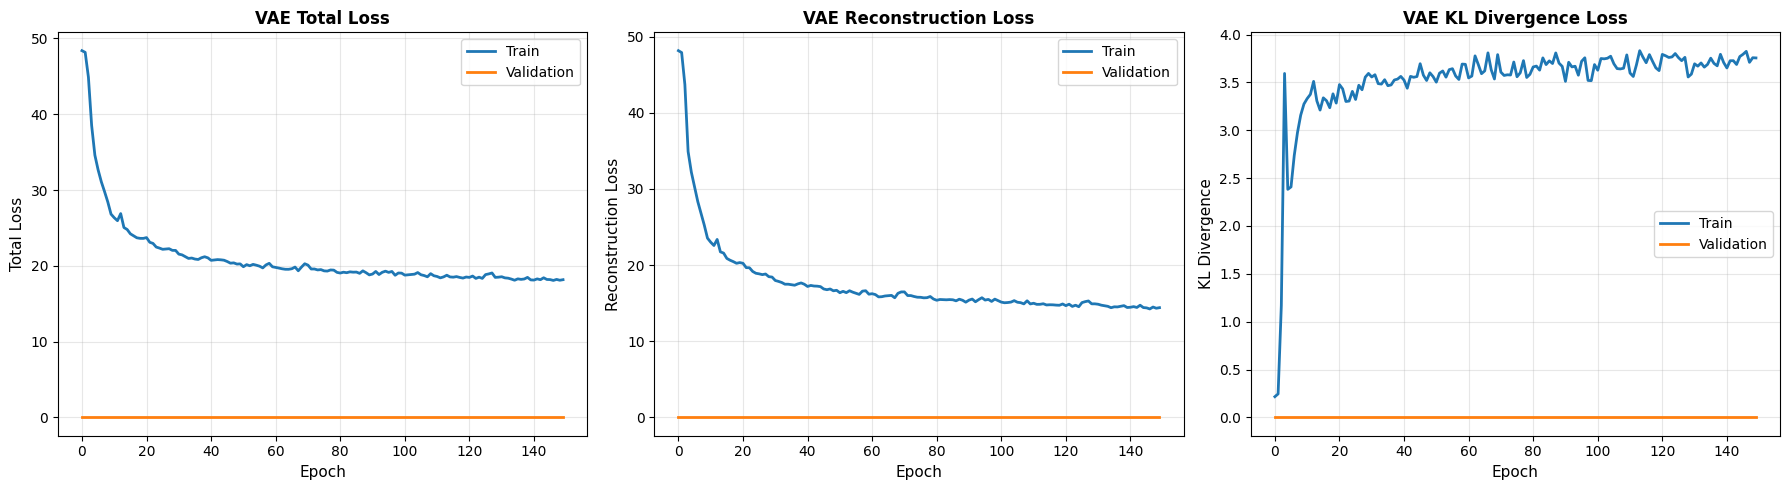

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Latent representation shape: (467, 2)
Latent mean per dimension: [0.00377194 0.09191152]
Latent std per dimension: [1.0154506 1.1348466]
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean reconstruction error: 0.3076
Std reconstruction error: 0.2586


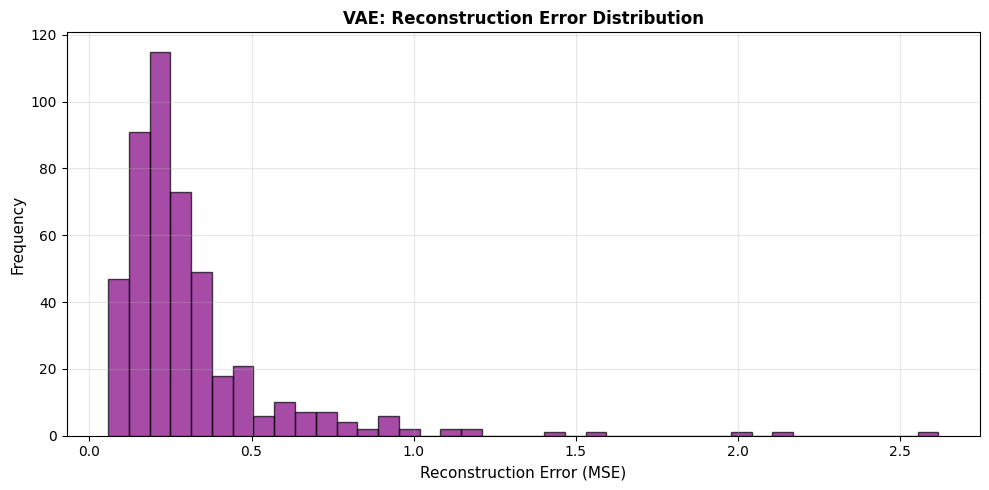

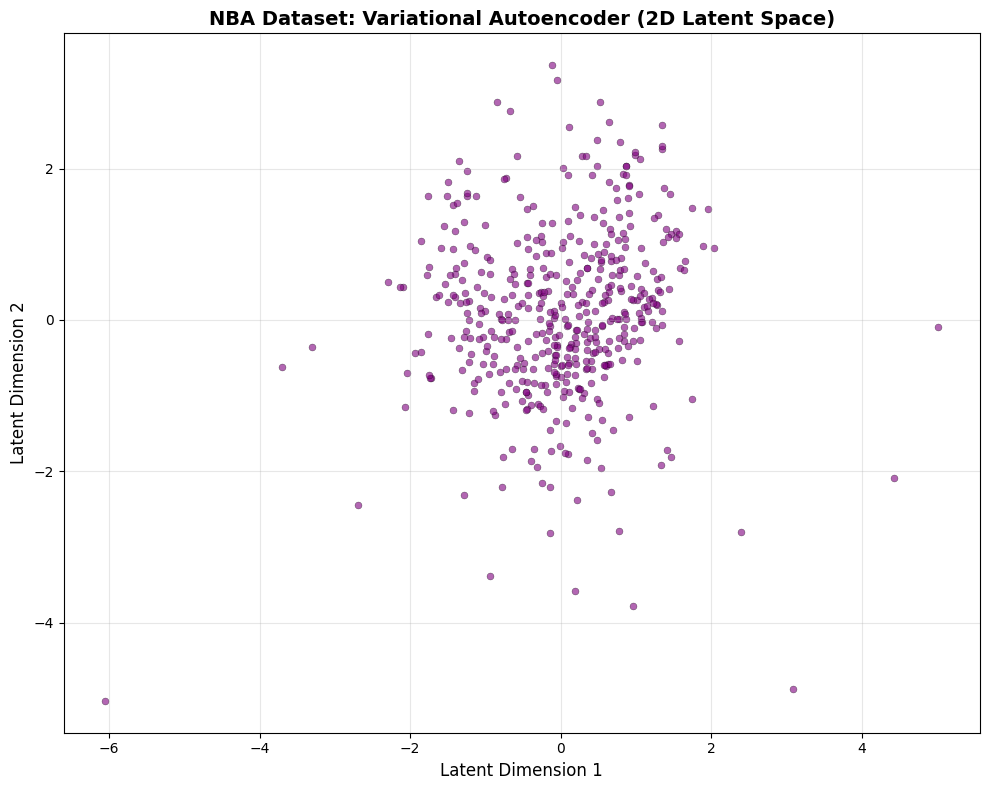

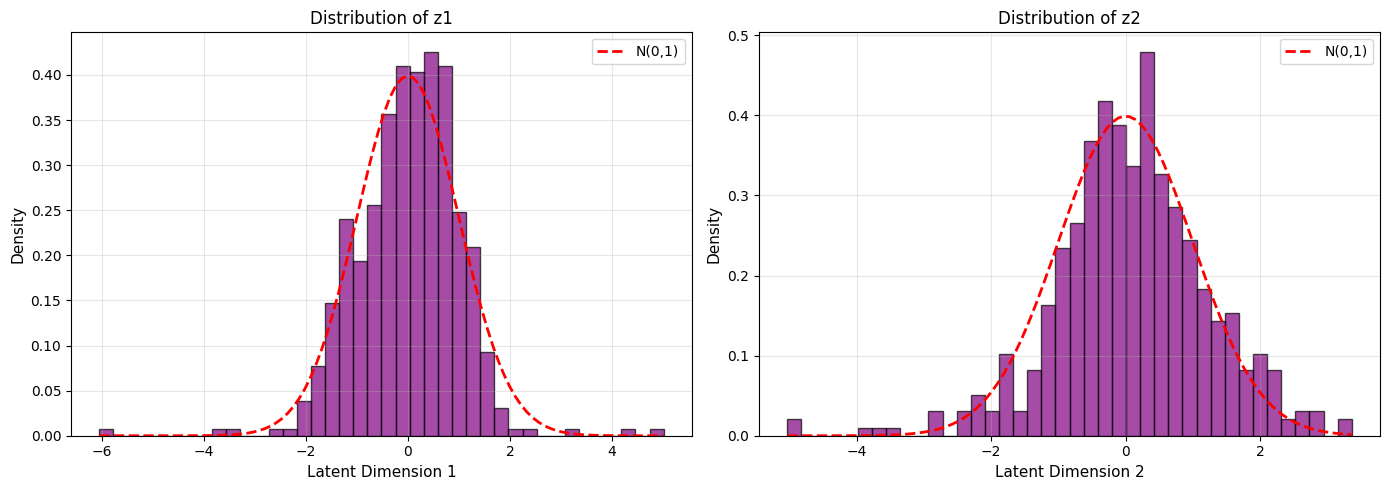

/Users/james/Documents/Projects/nba-dimensionality-reduction/dvenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/james/Documents/Projects/nba-dimensionality-reduction/dvenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/james/Documents/Projects/nba-dimensionality-reduction/dvenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/james/Documents/Projects/nba-dimensionality-reduction/dvenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/james/Documents/Projects/nba-dimensionality-reduction/dvenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/james/Documents/Projects/nba-dimensionality-re

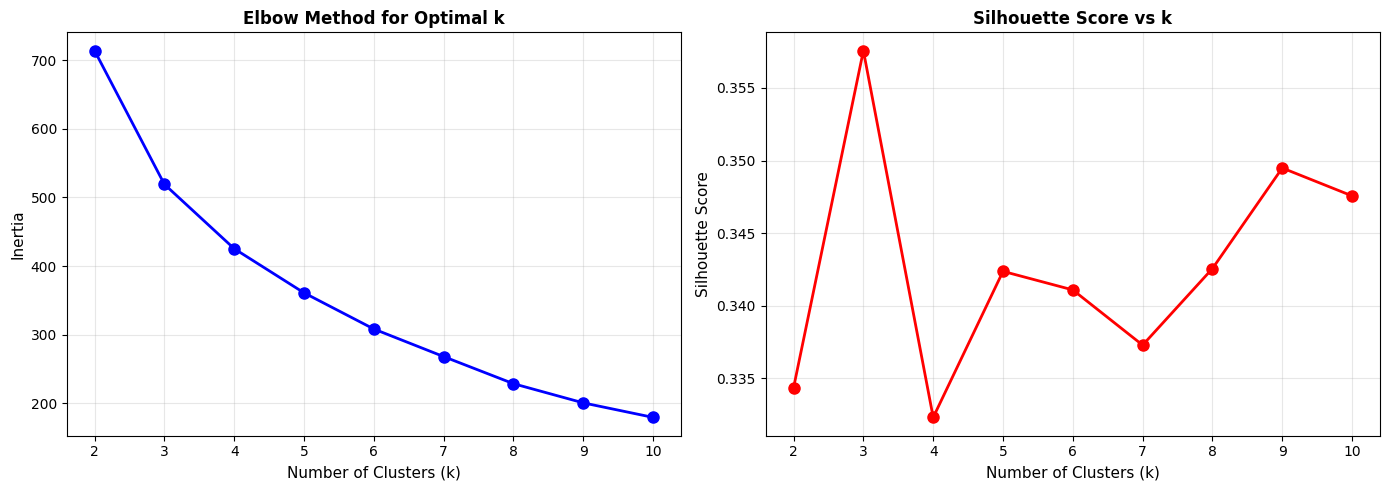

Silhouette scores by k:
  k=2: 0.3344
  k=3: 0.3576
  k=4: 0.3323
  k=5: 0.3424
  k=6: 0.3411
  k=7: 0.3373
  k=8: 0.3426
  k=9: 0.3495
  k=10: 0.3476

Cluster sizes (k=6):
  Cluster 0: 113 players
  Cluster 1: 130 players
  Cluster 2: 51 players
  Cluster 3: 32 players
  Cluster 4: 42 players
  Cluster 5: 99 players


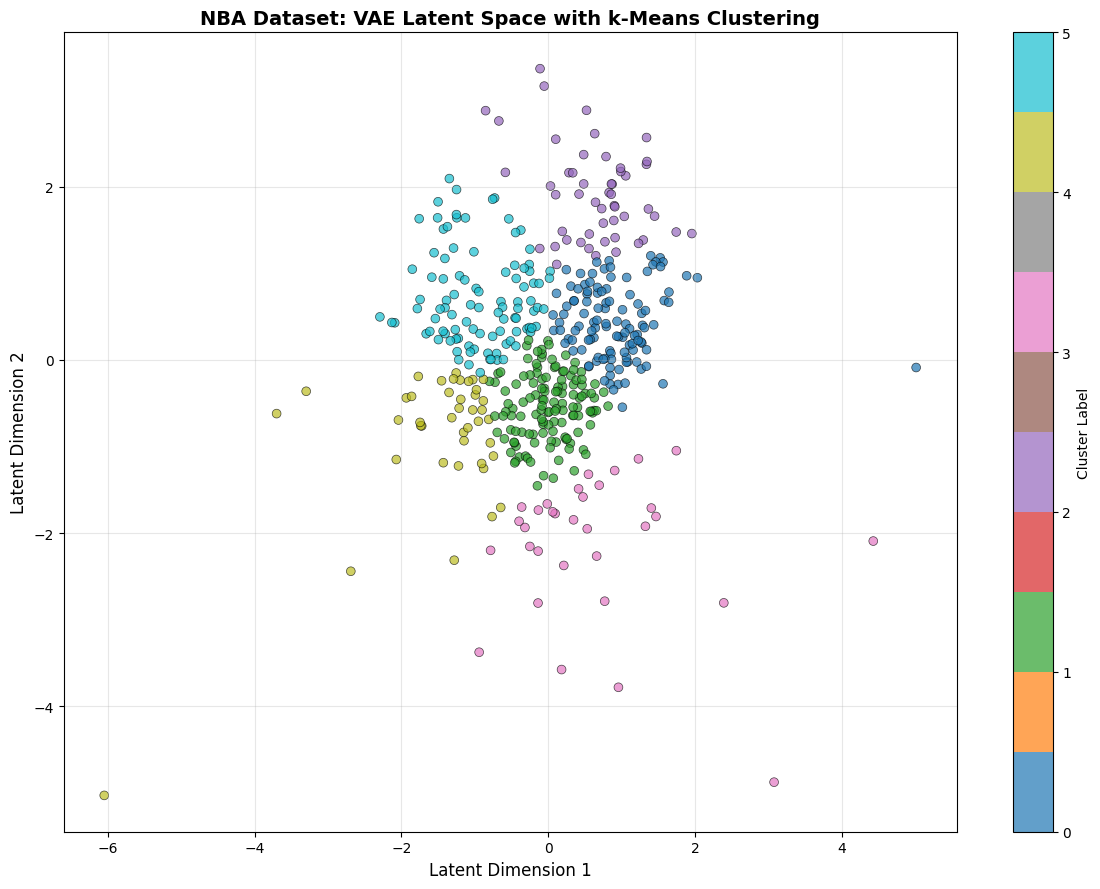


CLUSTER CHARACTERIZATION (Top 5 differentiating features by z-score)

--- Cluster 0 (n=113) ---
  Highest features (above average):
    3P          : +0.92σ
    3PA         : +0.89σ
    Total Minutes: +0.79σ
    MP          : +0.75σ
    GP          : +0.68σ
  Lowest features (below average):
    BLK%        : -0.32σ
    DRB%        : -0.49σ
    Unnamed: 0  : -0.52σ
    ORB%        : -0.56σ
    TRB%        : -0.60σ

--- Cluster 1 (n=130) ---
  Highest features (above average):
    3PAr        : +0.39σ
    Unnamed: 0  : +0.39σ
    3P%         : +0.13σ
    STL%        : -0.03σ
    FT%         : -0.09σ
  Lowest features (below average):
    VORP        : -0.57σ
    OWS         : -0.58σ
    2P          : -0.58σ
    WS          : -0.62σ
    GS          : -0.63σ

--- Cluster 2 (n=51) ---
  Highest features (above average):
    FT          : +2.11σ
    VORP        : +2.10σ
    2PA         : +2.10σ
    PTS         : +2.09σ
    FTA         : +2.06σ
  Lowest features (below average):
    TOV%   

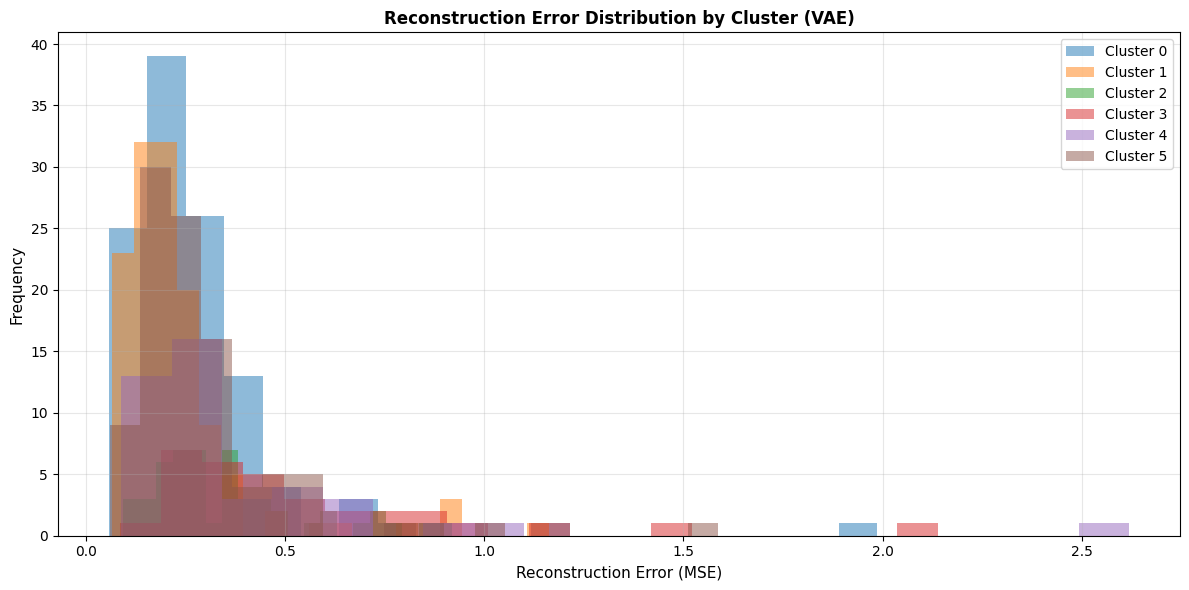

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Generated 400 synthetic player profiles from latent space grid

Synthetic data statistics (first 5 features):
  Unnamed: 0: mean=0.06, std=1.09
  Salary: mean=0.20, std=1.11
  Age: mean=0.09, std=0.34
  GP: mean=-0.36, std=1.06
  GS: mean=0.17, std=1.17


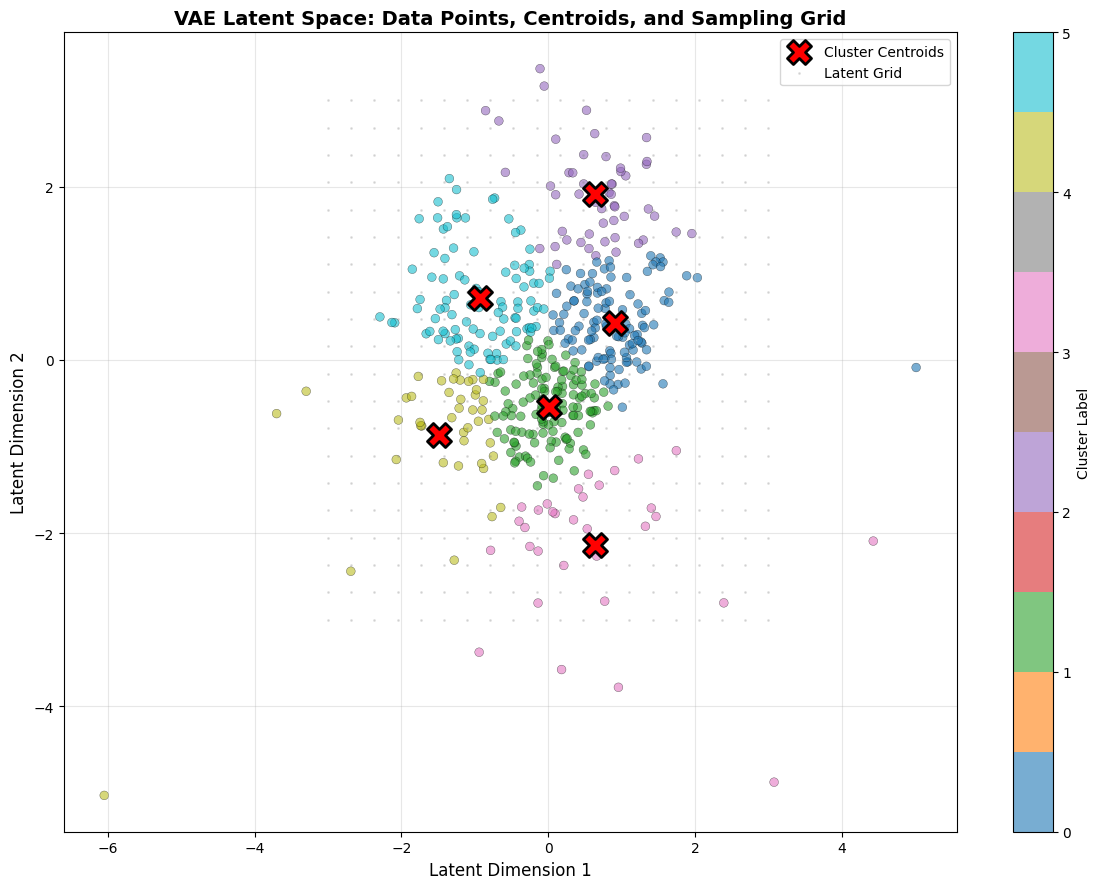

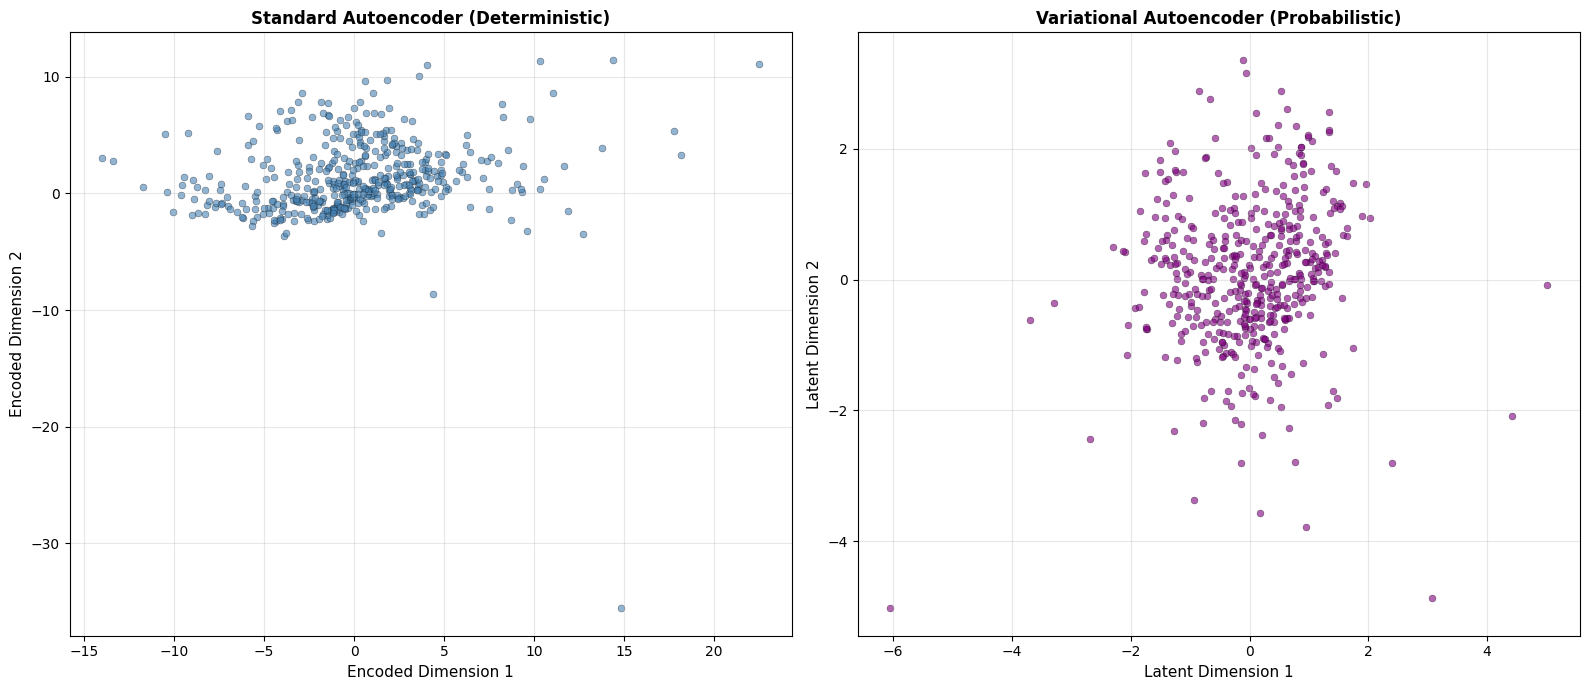


Key Differences:
  Standard AE: Learns deterministic encoding, can create 'holes' in latent space
  VAE: Learns probabilistic encoding, creates continuous/smooth latent space
  VAE latent space is more suitable for generation and interpolation
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


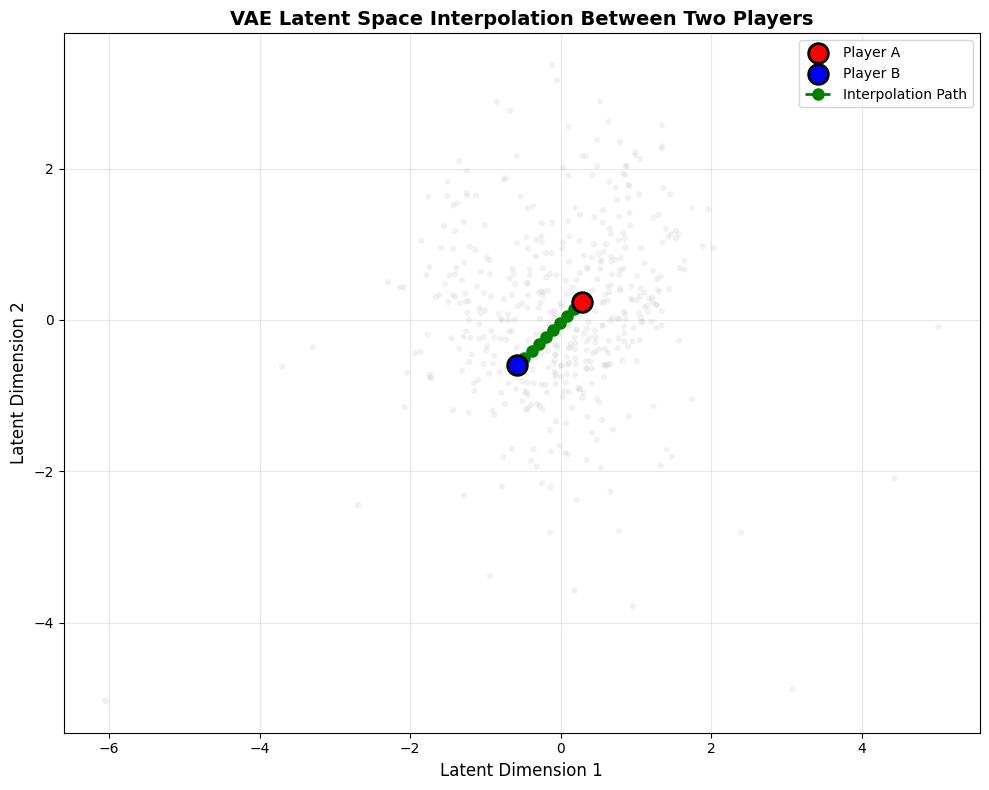


Interpolation between Player 36 and Player 392
Player A latent: [0.27504206 0.24329156]
Player B latent: [-0.57861334 -0.59796464]
Created 10 intermediate 'synthetic' players

✓ Variational Autoencoder (VAE) analysis complete!

All dimensionality reduction methods completed!
  ✓ Autoencoder (2D)
  ✓ Autoencoder + SOM
  ✓ Autoencoder + t-SNE
  ✓ Autoencoder + UMAP
  ✓ Variational Autoencoder (VAE)


In [333]:
# %% [markdown]
# Question 2.1(e): Variational Autoencoder (VAE)

# %%
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, backend as K
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Use the existing cleaned data (xScaled, xTrain, xTest from previous sections)

# %% [markdown]
# ### Step 1: Build Variational Autoencoder (VAE)
# VAE differs from standard AE by learning a probabilistic latent space.
# It consists of:
# 1. Encoder: Maps input to latent distribution parameters (mean, log_variance)
# 2. Sampling layer: Samples from the latent distribution
# 3. Decoder: Reconstructs input from latent sample
# 
# The loss combines reconstruction error and KL divergence (regularization).

# %%
inputDimension = xTrain.shape[1]
latentDimension = 2  # Direct reduction to 2D for visualization

# Build Encoder
encoder_input = layers.Input(shape=(inputDimension,), name='encoder_input')
x = layers.Dense(128, activation='relu')(encoder_input)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

# Instead of outputting latent directly, output mean and log_variance
z_mean = layers.Dense(latentDimension, name='z_mean')(x)
z_log_var = layers.Dense(latentDimension, name='z_log_var')(x)

# Sampling layer: uses reparameterization trick
# z = mean + exp(log_var/2) * epsilon, where epsilon ~ N(0,1)
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the latent vector."""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])

# Create encoder model
encoder_vae = models.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')

print("Encoder architecture:")
encoder_vae.summary()

# %%
# Build Decoder
latent_input = layers.Input(shape=(latentDimension,), name='latent_input')
x = layers.Dense(32, activation='relu')(latent_input)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
decoder_output = layers.Dense(inputDimension, activation='linear')(x)

# Create decoder model
decoder_vae = models.Model(latent_input, decoder_output, name='decoder')

print("\nDecoder architecture:")
decoder_vae.summary()

# %%
# Build complete VAE
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Reconstruction loss (MSE)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(data - reconstruction), axis=1
                )
            )
            
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )
            
            # Total loss
            total_loss = reconstruction_loss + kl_loss
        
        # Compute gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.square(data - reconstruction), axis=1
            )
        )
        
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
        )
        
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "total_loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Instantiate VAE
vae = VAE(encoder_vae, decoder_vae)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

print("\nVAE model created successfully!")

# %% [markdown]
# ### Step 2: Train the VAE

# %%
# Train VAE
history_vae = vae.fit(
    xTrain, 
    epochs=150,
    batch_size=32,
    validation_data=(xTest,),  # Pass as single-element tuple
    verbose=1
)

# %%
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Total loss
axes[0].plot(history_vae.history['total_loss'], label='Train', linewidth=2)
axes[0].plot(history_vae.history['val_total_loss'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Total Loss', fontsize=11)
axes[0].set_title('VAE Total Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reconstruction loss
axes[1].plot(history_vae.history['reconstruction_loss'], label='Train', linewidth=2)
axes[1].plot(history_vae.history['val_reconstruction_loss'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Reconstruction Loss', fontsize=11)
axes[1].set_title('VAE Reconstruction Loss', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# KL divergence loss
axes[2].plot(history_vae.history['kl_loss'], label='Train', linewidth=2)
axes[2].plot(history_vae.history['val_kl_loss'], label='Validation', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=11)
axes[2].set_ylabel('KL Divergence', fontsize=11)
axes[2].set_title('VAE KL Divergence Loss', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %% [markdown]
# ### Step 3: Extract Latent Representations

# %%
# Get latent representations (use mean for deterministic embedding)
z_mean_all, z_log_var_all, z_sample_all = encoder_vae.predict(xScaled)

# Use z_mean for visualization (deterministic)
X_vae = z_mean_all

print(f"Latent representation shape: {X_vae.shape}")
print(f"Latent mean per dimension: {X_vae.mean(axis=0)}")
print(f"Latent std per dimension: {X_vae.std(axis=0)}")

# %%
# Calculate reconstruction error
X_reconstructed_vae = vae.predict(xScaled)
reconstruction_errors_vae = np.mean(np.square(xScaled - X_reconstructed_vae), axis=1)

print(f"Mean reconstruction error: {np.mean(reconstruction_errors_vae):.4f}")
print(f"Std reconstruction error: {np.std(reconstruction_errors_vae):.4f}")

# Plot reconstruction error distribution
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors_vae, bins=40, color='purple', edgecolor='k', alpha=0.7)
plt.xlabel('Reconstruction Error (MSE)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('VAE: Reconstruction Error Distribution', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %% [markdown]
# ### Step 4: Visualize Latent Space

# %%
# Visualize the 2D latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_vae[:, 0], X_vae[:, 1], 
                     s=25, alpha=0.6, c='purple', 
                     edgecolors='k', linewidth=0.3)
plt.xlabel('Latent Dimension 1', fontsize=12)
plt.ylabel('Latent Dimension 2', fontsize=12)
plt.title('NBA Dataset: Variational Autoencoder (2D Latent Space)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check if latent space follows approximate Gaussian distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i in range(2):
    axes[i].hist(X_vae[:, i], bins=40, density=True, alpha=0.7, color='purple', edgecolor='k')
    
    # Overlay theoretical N(0,1) for comparison
    x_range = np.linspace(X_vae[:, i].min(), X_vae[:, i].max(), 100)
    from scipy.stats import norm
    axes[i].plot(x_range, norm.pdf(x_range, 0, 1), 'r--', linewidth=2, label='N(0,1)')
    
    axes[i].set_xlabel(f'Latent Dimension {i+1}', fontsize=11)
    axes[i].set_ylabel('Density', fontsize=11)
    axes[i].set_title(f'Distribution of z{i+1}', fontsize=12)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %% [markdown]
# ### Step 5: Apply k-Means Clustering on VAE Latent Space

# %%
# Determine optimal number of clusters
inertias_vae = []
silhouette_scores_vae = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels_temp = kmeans_temp.fit_predict(X_vae)
    inertias_vae.append(kmeans_temp.inertia_)
    silhouette_scores_vae.append(silhouette_score(X_vae, labels_temp))

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias_vae, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Inertia', fontsize=11)
axes[0].set_title('Elbow Method for Optimal k', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores_vae, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Score vs k', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Silhouette scores by k:")
for k, score in zip(K_range, silhouette_scores_vae):
    print(f"  k={k}: {score:.4f}")

# %%
# Apply k-Means with chosen k
k = 6  # Adjust based on elbow/silhouette analysis
kmeans_vae = KMeans(n_clusters=k, n_init=20, random_state=42)
labels_vae = kmeans_vae.fit_predict(X_vae)

# Cluster statistics
unique_labels, counts = np.unique(labels_vae, return_counts=True)
print(f"\nCluster sizes (k={k}):")
for label, count in zip(unique_labels, counts):
    print(f"  Cluster {label}: {count} players")

# %%
# Visualize clustered VAE latent space
plt.figure(figsize=(12, 9))
scatter = plt.scatter(
    X_vae[:, 0], X_vae[:, 1],
    c=labels_vae,
    cmap='tab10',
    s=40,
    alpha=0.7,
    edgecolors='k',
    linewidth=0.5
)
plt.colorbar(scatter, label='Cluster Label', ticks=range(k))
plt.xlabel('Latent Dimension 1', fontsize=12)
plt.ylabel('Latent Dimension 2', fontsize=12)
plt.title('NBA Dataset: VAE Latent Space with k-Means Clustering', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %% [markdown]
# ### Step 6: Analyze Cluster Characteristics

# %%
# Add cluster labels to the dataframe
dfAnalysis = dfCleaned.copy()
dfAnalysis['Cluster_VAE'] = labels_vae

# Statistical summary by cluster
numeric_cols = dfCleaned.select_dtypes(include=[np.number]).columns
cluster_summary = dfAnalysis.groupby('Cluster_VAE')[numeric_cols].mean()

# Calculate z-scores relative to global mean
global_mean = dfAnalysis[numeric_cols].mean()
global_std = dfAnalysis[numeric_cols].std()
cluster_zscore = (cluster_summary - global_mean) / global_std

# Display top differentiating features per cluster
print("\n" + "="*80)
print("CLUSTER CHARACTERIZATION (Top 5 differentiating features by z-score)")
print("="*80)

for cluster_id in range(k):
    print(f"\n--- Cluster {cluster_id} (n={counts[cluster_id]}) ---")
    z = cluster_zscore.loc[cluster_id].sort_values(ascending=False)
    
    print("  Highest features (above average):")
    for feat, val in z.head(5).items():
        print(f"    {feat:12s}: {val:+.2f}σ")
    
    print("  Lowest features (below average):")
    for feat, val in z.tail(5).items():
        print(f"    {feat:12s}: {val:+.2f}σ")

# %%
# Show example players from each cluster
print("\n" + "="*80)
print("EXAMPLE PLAYERS PER CLUSTER")
print("="*80)

for cluster_id in range(k):
    cluster_players = dfAnalysis[dfAnalysis['Cluster_VAE'] == cluster_id]
    
    # Sample random players or top by a metric
    if 'Player Name' in dfCleaned.columns and 'PTS' in dfCleaned.columns:
        sample = cluster_players.nlargest(5, 'PTS')[['Player Name', 'PTS', 'Age', 'MP']]
        print(f"\nCluster {cluster_id} - Top 5 by PTS:")
        print(sample.to_string(index=False))

# %%
# Reconstruction error by cluster
recon_by_cluster = pd.DataFrame({
    'Cluster': labels_vae,
    'Reconstruction_Error': reconstruction_errors_vae
})

print("\n" + "="*80)
print("RECONSTRUCTION ERROR BY CLUSTER")
print("="*80)
print(recon_by_cluster.groupby('Cluster')['Reconstruction_Error'].describe())

# Visualize reconstruction error distribution by cluster
plt.figure(figsize=(12, 6))
for cluster_id in range(k):
    cluster_errors = recon_by_cluster[recon_by_cluster['Cluster'] == cluster_id]['Reconstruction_Error']
    plt.hist(cluster_errors, bins=20, alpha=0.5, label=f'Cluster {cluster_id}')

plt.xlabel('Reconstruction Error (MSE)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Reconstruction Error Distribution by Cluster (VAE)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %% [markdown]
# ### Step 7: Explore the Latent Space - Generate Synthetic Samples

# %%
# One unique property of VAE: we can sample from the latent space to generate new data
# Let's visualize the latent space with a grid and decode points

# Create a grid in latent space
n_grid = 20
grid_x = np.linspace(-3, 3, n_grid)
grid_y = np.linspace(-3, 3, n_grid)

# Sample points from the grid
sampled_points = []
for x in grid_x:
    for y in grid_y:
        sampled_points.append([x, y])

sampled_points = np.array(sampled_points)

# Decode the sampled points
decoded_samples = decoder_vae.predict(sampled_points)

print(f"Generated {len(decoded_samples)} synthetic player profiles from latent space grid")

# Show some statistics of decoded samples
print("\nSynthetic data statistics (first 5 features):")
feature_names = dfCleaned.select_dtypes(include=[np.number]).columns[:5]
for i, feat in enumerate(feature_names):
    print(f"  {feat}: mean={decoded_samples[:, i].mean():.2f}, std={decoded_samples[:, i].std():.2f}")

# %%
# Visualize latent space with cluster boundaries
plt.figure(figsize=(12, 9))

# Plot cluster centroids
centroids = kmeans_vae.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], 
           c='red', marker='X', s=300, edgecolors='black', 
           linewidth=2, label='Cluster Centroids', zorder=10)

# Plot data points colored by cluster
scatter = plt.scatter(X_vae[:, 0], X_vae[:, 1],
                     c=labels_vae, cmap='tab10',
                     s=40, alpha=0.6, edgecolors='k', linewidth=0.3)

# Plot grid samples (faintly) to show coverage
plt.scatter(sampled_points[:, 0], sampled_points[:, 1],
           c='gray', marker='.', s=5, alpha=0.2, label='Latent Grid')

plt.colorbar(scatter, label='Cluster Label', ticks=range(k))
plt.xlabel('Latent Dimension 1', fontsize=12)
plt.ylabel('Latent Dimension 2', fontsize=12)
plt.title('VAE Latent Space: Data Points, Centroids, and Sampling Grid', 
         fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %% [markdown]
# ### Step 8: Compare VAE vs Standard Autoencoder

# %%
# If you have the standard AE results from previous sections, compare them
# Let's create a comparison visualization

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot standard AE (if X_encoded exists from earlier)
if 'X_encoded' in globals():
    axes[0].scatter(X_encoded[:, 0], X_encoded[:, 1], 
                   s=25, alpha=0.6, c='steelblue', edgecolors='k', linewidth=0.3)
    axes[0].set_xlabel('Encoded Dimension 1', fontsize=11)
    axes[0].set_ylabel('Encoded Dimension 2', fontsize=11)
    axes[0].set_title('Standard Autoencoder (Deterministic)', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'Standard AE not available\nRun Question 2.1(a) first', 
                ha='center', va='center', transform=axes[0].transAxes, fontsize=12)
    axes[0].set_title('Standard Autoencoder', fontsize=12, fontweight='bold')

# Plot VAE
axes[1].scatter(X_vae[:, 0], X_vae[:, 1], 
               s=25, alpha=0.6, c='purple', edgecolors='k', linewidth=0.3)
axes[1].set_xlabel('Latent Dimension 1', fontsize=11)
axes[1].set_ylabel('Latent Dimension 2', fontsize=11)
axes[1].set_title('Variational Autoencoder (Probabilistic)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Differences:")
print("  Standard AE: Learns deterministic encoding, can create 'holes' in latent space")
print("  VAE: Learns probabilistic encoding, creates continuous/smooth latent space")
print("  VAE latent space is more suitable for generation and interpolation")

# %% [markdown]
# ### Step 9: Latent Space Interpolation

# %%
# Demonstrate interpolation between two players
# Pick two random players from different clusters

cluster_pairs = [(labels_vae == i) for i in range(min(2, k))]
if len(cluster_pairs) >= 2:
    idx1 = np.random.choice(np.where(cluster_pairs[0])[0])
    idx2 = np.random.choice(np.where(cluster_pairs[1])[0])
    
    z1 = X_vae[idx1]
    z2 = X_vae[idx2]
    
    # Create interpolation
    n_steps = 10
    alphas = np.linspace(0, 1, n_steps)
    interpolated_z = np.array([alpha * z2 + (1 - alpha) * z1 for alpha in alphas])
    
    # Decode interpolated points
    interpolated_decoded = decoder_vae.predict(interpolated_z)
    
    # Visualize interpolation path
    plt.figure(figsize=(10, 8))
    plt.scatter(X_vae[:, 0], X_vae[:, 1], 
               c='lightgray', s=20, alpha=0.3, edgecolors='none')
    plt.scatter(z1[0], z1[1], c='red', s=200, marker='o', 
               edgecolors='black', linewidth=2, label='Player A', zorder=10)
    plt.scatter(z2[0], z2[1], c='blue', s=200, marker='o', 
               edgecolors='black', linewidth=2, label='Player B', zorder=10)
    plt.plot(interpolated_z[:, 0], interpolated_z[:, 1], 
            'g--', linewidth=2, marker='o', markersize=8, 
            label='Interpolation Path', zorder=5)
    
    plt.xlabel('Latent Dimension 1', fontsize=12)
    plt.ylabel('Latent Dimension 2', fontsize=12)
    plt.title('VAE Latent Space Interpolation Between Two Players', 
             fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nInterpolation between Player {idx1} and Player {idx2}")
    print(f"Player A latent: {z1}")
    print(f"Player B latent: {z2}")
    print(f"Created {n_steps} intermediate 'synthetic' players")

# %% [markdown]
# ### Summary: Variational Autoencoder (VAE)
# 
# **Methodology:**
# 1. Built a VAE with encoder outputting mean and log-variance of latent distribution
# 2. Used reparameterization trick for backpropagation through sampling
# 3. Trained with combined loss: reconstruction error + KL divergence
# 4. Extracted 2D latent representations using the mean (z_mean)
# 5. Applied k-Means clustering on the latent space
# 
# **Key Advantages of VAE:**
# - **Probabilistic latent space**: Each point represents a distribution, not a single value
# - **Continuous latent space**: No gaps or holes, smooth transitions between regions
# - **Generative capability**: Can sample new synthetic data from the latent space
# - **Regularized**: KL divergence encourages latent space to follow N(0,1) distribution
# - **Interpretable**: Latent dimensions can capture meaningful variations
# 
# **Comparison with Standard Autoencoder:**
# - Standard AE can create disconnected regions in latent space
# - VAE forces continuity through probabilistic encoding and KL regularization
# - VAE is better for generation tasks, but may sacrifice reconstruction accuracy
# - Standard AE often gives sharper reconstructions but less organized latent space
# 
# **Observations:**
# - The latent space approximately follows a Gaussian distribution (as regularized)
# - Clusters form naturally but with smooth transitions (no hard boundaries)
# - Can generate realistic synthetic player profiles by sampling the latent space
# - Interpolation between players creates plausible intermediate profiles
# - The probabilistic nature provides uncertainty estimates for each encoding
# 
# **Trade-offs:**
# - VAE reconstruction error may be slightly higher than standard AE
# - The KL divergence term acts as a regularizer, preventing overfitting
# - Latent space is more suitable for downstream tasks like generation and interpolation

print("\n✓ Variational Autoencoder (VAE) analysis complete!")
print("\n" + "="*80)
print("All dimensionality reduction methods completed!")
print("  ✓ Autoencoder (2D)")
print("  ✓ Autoencoder + SOM")
print("  ✓ Autoencoder + t-SNE")
print("  ✓ Autoencoder + UMAP")
print("  ✓ Variational Autoencoder (VAE)")
print("="*80)